**Комментарии к коду:**
1. Полное время выполнения кода в Google Colab c GPU около 27 мин.
2. Максимальная загрузка GPU - 13.8 GB.
3. Единственное место, где код может остановится - запуск Elasticsearch (очень редко "!sleep 50" недостаточно)

#Введение

В настоящей работе рассматривается экстрактивная вопросно-ответная система (ВОС) для получения ответа из технической документации.
Мы полагаем, что для указанной цели такая система является оптимальной,  хотя для других задач могут быть более подходящими другие типы ВОС.
Например, ВОС сообщества пользователей включает в себя сбор вопросно-ответных пар, которые создаются пользователями на форумах, таких как Stack Overflow, а затем используются для поиска по семантическому сходству, чтобы найти наиболее близкий ответ на новый вопрос.
Существует также тип ВОС, целью которой является создание развернутых ответов длиной в абзац на вопросы, на которые нельзя дать односложный ответ, такие как: «Почему небо голубое?»

По области сбора данных ВОС классифицируется как открытого и закрытого типа. ВОС закрытого типа имеют дело с вопросами по узкой теме, такой как ответ по отдельной инструкции(случай рассматриваемый здесь). ВОС открытого типа имеет дело с вопросами практически обо всем.

В дополнение к этому можно также отметить, что существуют ВОС выполняющие поиск ответа в таблицах, а модели преобразования, такие как TAPAS, могут выполнять агрегирование информации из различных граф для получения окончательного ответа.

**Данные для оценки и обучения системы**

В настояще работе мы будем строить экстрактивную ВОС для получения ответов по довольно объемной и сложной технической инструкции прибора.
Однако по данной инструкции отстуствуют вопросно-ответные пары, которые можно было бы использовать для проверки качества и дообучения модели трансформера, которая лежит в основе ВОС.

Поэтому в качестве контрольного и обучающего датасета вопросно-ответных пар был выбран датасет XQUAD. Положительными особенностями данного датасета являются:
- удобная структура, которая идентична структуре широкоизветного датасета SQUAD v1.1;
- наличие вопросно-ответных пар на 11 языках, включая русский;
- небольшой объем, что удобно для работы с ограниченными вычислительными ресурсами(как в нашем случае) и имитирует реальную ситуацию, когда имеется ограниченное количество вопросно-ответных пар, поскольку процесс подготовки таких данных является трудоемким.

В тоже время данный датасет имеет 2 недостатка:
- он создан на основе статей в Википедии, которые имеют общий характер, а в данной работе рассматриваются вопросы из технической области;
- в датасете отсутствуют вопросы без ответов, что не позволяет провести качественное дообучение нашей ВОС для такого типа вопросов.

# Подготовка к работе

In [ ]:
# load the necessary libraries
import torch
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Специализированные библиотеки**

Наша вопросно-ответной системы будет использовать библиотеку haystack и и облачную базу данных elasticsearch. Мы будем также использовать популярную библиотеку моделей huggingface(transformers), которая загружается в рамках пакета farm-haystack.

Загрузим эти библиотеки:

In [ ]:
!pip install farm-haystack[elasticsearch,metrics,inference] # version 1.17.2 has to work with RAGenerator
# for version 1.17.2 "inference" must be loaded separately

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.0/764.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.9 MB/s eta 0:00:

In [ ]:
# let's see what version of haystack is loaded
import haystack
haystack.__version__

'1.19.0'

In [ ]:
# import transformers and see what version
import transformers

# print only error messages
transformers.logging.set_verbosity_error()
transformers.__version__

'4.31.0'

Определим сервисную функцию для очистки памяти GPU

In [ ]:
# function for clearning GPU memory
#example: GPU before - 11GB, after - 4.8GB
def clean_gpu():
  gc_number = 100
  while gc_number > 6:
    torch.cuda.empty_cache()
    gc_number = gc.collect()
    print('gc_number = ', gc_number)


**Disable Tokenizers Parallelism**

Предупреждения возникают всякий раз, когда используется многопроцессорная обработка (часто используется загрузчиками данных). Чтобы отключить это предупреждение, установим для переменной среды TOKENIZERS_PARALLELISM=False. По умолчанию мы отключаем параллелизм, чтобы избежать любых скрытых взаимоблокировок, которые трудно отладить. (При использовании pytorch для обучения модели huggingface-трансформеров предупреждение может возникать каждую эпоху.)

In [ ]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


Отключаем ведение журнала Haystack

In [ ]:
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base",
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# Загрузка, анализ и преобразование датасета xquad.ru

XQuAD (Cross-lingual Question Answering Dataset)является эталонным набором данных для оценки эффективности вопросно-ответных систем на разных языках. Набор данных состоит из подмножества 240 абзацев и 1190 пар вопросов и ответов датасета SQuAD v1.1 [Rajpurkar et al., 2016] cовместно с их переводами на десять языков: испанский, немецкий, греческий, русский, турецкий , арабский, вьетнамский, тайский, китайский и хинди. Таким образом, набор данных полностью идентичен для 11 языков. XQuAD имеет формат польность повторяющий формат датасета SQuAD v.1.1

In [ ]:
# load file with xquad.ru dataset from github
!wget https://raw.githubusercontent.com/deepmind/xquad/master/xquad.ru.json -O /content/xquad.ru.json

--2023-08-21 09:03:46--  https://raw.githubusercontent.com/deepmind/xquad/master/xquad.ru.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1896368 (1.8M) [text/plain]
Saving to: ‘/content/xquad.ru.json’

/content/xquad.ru.j 100%[===================>]   1.81M  --.-KB/s    in 0.02s   

2023-08-21 09:03:47 (82.5 MB/s) - ‘/content/xquad.ru.json’ saved [1896368/1896368]



In [ ]:
# read 'xquad.ru.json'
with open("/content/xquad.ru.json", 'r') as fp:
        # convert JSON-file to Python dictionary
        di_data = json.load(fp)
di_data.keys()

dict_keys(['data', 'version'])

Файлы json формата SQuAD имеют структуру вложенных друг в друга(как матрешка) списков и словарей. Определим точную структуру данных датасета XQuAD:

In [ ]:
# let's see the content of the "data" column
df_di = pd.DataFrame(di_data)
print('Number of data blocks(articles) in dataset: ', len(df_di.data))
print('Keys of a data block: ',df_di.data[0].keys())
print('Type of paragraphs data: ',type(df_di.data[0]['paragraphs']))
print('Type of title data: ',type(df_di.data[0]['title']))

Number of data blocks(articles) in dataset:  48
Keys of a data block:  dict_keys(['paragraphs', 'title'])
Type of paragraphs data:  <class 'list'>
Type of title data:  <class 'str'>


In [ ]:
# let's see the content of a "paragraphs" list
print('Number of paragraphs in article "0": ',len(df_di.data[0]['paragraphs']))
print('Keys of paragraphs: ', df_di.data[0]['paragraphs'][0].keys())
print('Type of context data: ', type(df_di.data[0]['paragraphs'][0]['context']))
print('Type of qas data: ', type(df_di.data[0]['paragraphs'][0]['qas']))

Number of paragraphs in article "0":  5
Keys of paragraphs:  dict_keys(['context', 'qas'])
Type of context data:  <class 'str'>
Type of qas data:  <class 'list'>


In [ ]:
# let's see the content of a "qas" list
print('Number of questions(qas) to paragraph "0": ', len(df_di.data[0]['paragraphs'][0]['qas']))
print('Keys of qas: ',df_di.data[0]['paragraphs'][0]['qas'][0].keys())
print('Type of answers data: ',type(df_di.data[0]['paragraphs'][0]['qas'][0]['answers']))
print('Type of id data: ',type(df_di.data[0]['paragraphs'][0]['qas'][0]['id']))
print('Type of question data: ',type(df_di.data[0]['paragraphs'][0]['qas'][0]['question']))

Number of questions(qas) to paragraph "0":  14
Keys of qas:  dict_keys(['answers', 'id', 'question'])
Type of answers data:  <class 'list'>
Type of id data:  <class 'str'>
Type of question data:  <class 'str'>


In [ ]:
# let's see the content of a "answers" list
print('Количество данных в каждом блоке : ', len(df_di.data[0]['paragraphs'][0]['qas'][0]['answers']))
print('Keys of answers: ',df_di.data[0]['paragraphs'][0]['qas'][0]['answers'][0].keys())
print('Type of answer_start data: ',type(df_di.data[0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']))
print('Type of text data: ',type(df_di.data[0]['paragraphs'][0]['qas'][0]['answers'][0]['text']))

Количество данных в каждом блоке :  1
Keys of answers:  dict_keys(['answer_start', 'text'])
Type of answer_start data:  <class 'int'>
Type of text data:  <class 'str'>


Мы дошли до последнего уровня "матрешки", на котором все данные имеют тип либо string либо integer.

**Структура исходного датафрема с данными XQuAD**:
 - в столбце "data" содержится 48 блоков данных(title), соответствующих одной из статей в Википедии;
 - каждый блок данных датасета(title) содержит 5 параграфов, т.е. в датасете всего 240 параграфов;
 - текст параграфа содержится в поле *context*, параграфу соответствует несколько(от 1 до 17) вопросных блоков(qas), каждый вопросный блок содержит уникальный идентификатор вопроса(id) и список *answer*;
 - список *answer* содержит текст ответа(text) и начало ответа в параграфе(start_answer).


In [ ]:
# let's see what the data looks like at the dicionary level "qas"
df_di.data[47]['paragraphs'][1]['qas']

[{'answers': [{'answer_start': 93, 'text': 'Исаак Ньютон'}],
  'id': '5737821cc3c5551400e51f19',
  'question': 'Кто сформулировал закон всемирного тяготения?'},
 {'answers': [{'answer_start': 493, 'text': 'XX'}],
  'id': '5737821cc3c5551400e51f1a',
  'question': 'В каком веке появилась квантовая механика? '},
 {'answers': [{'answer_start': 1500, 'text': 'объединения'}],
  'id': '5737821cc3c5551400e51f1b',
  'question': 'Какого рода самосогласованные модели пытаются разработать физики для создания теории всего?'},
 {'answers': [{'answer_start': 1475,
    'text': 'самосогласованные модели объединения'}],
  'id': '5737821cc3c5551400e51f1c',
  'question': 'Какую физическую модель не удалось построить Эйнштейну?'}]

В дальнейше нам будет удобно работать с данными, содержащими начало ответа и текст ответа в формате list, ниже показано, как этого можно достичь.

In [ ]:
print('Example of answer(text) in list format: ',list(df_di.data[47]['paragraphs'][1]['qas'][0]['answers'][0].values())[1:])
print('Example of answer_start in list format: ', list(df_di.data[47]['paragraphs'][1]['qas'][0]['answers'][0].values())[:1])

Example of answer(text) in list format:  ['Исаак Ньютон']
Example of answer_start in list format:  [93]


Cконструируем датафрейм, в котором каждый тип данных будет содержаться в своем отдельном столбце.

In [ ]:
columns=['id','title','context','context_id','question','answers.text', 'answers.answer_start']
df_xq_full = pd.DataFrame(columns=columns)
parag_id = 0
# итеррируем индекс и содержание строк DataFrame
for index, row in df_di.iterrows():
  title = row.data['title']
  #print("title =", title)
  # делаем итеррацию по словарю row.data['paragraphs']
  for parag in row.data['paragraphs']:
    cont = parag['context']
    cont_id = parag_id
    parag_id += 1
    # делаем итеррацию по словарю parag['qas']
    for qa in parag['qas']:
      id = qa['id']
      quest = qa['question']
      answer_start = list(qa['answers'][0].values())[:1]
      answer_text = list(qa['answers'][0].values())[1:]
      temp_df = pd.DataFrame([[id,title,cont,cont_id, quest, answer_text, answer_start]], columns=columns)
      df_xq_full = pd.concat([df_xq_full,temp_df], ignore_index=True)

In [ ]:
# cheque the dataframe
df_xq_full.tail(5)

,id,title,context,context_id,question,answers.text,answers.answer_start
1185,57378c9b1c456719005744aa,Force,Определяя электрический ток как скорость измен...,238,Какая величина может быть записана как сумма э...,[электростатической силы],[359]
1186,5737a25ac3c5551400e51f51,Force,"где — площадь поперечного сечения, соответств...",239,Что вызывает напряжение в конструкциях?,[Тензор напряжений],[409]
1187,5737a25ac3c5551400e51f52,Force,"где — площадь поперечного сечения, соответств...",239,Какая величина используется для расчета площад...,[компоненты давления],[143]
1188,5737a25ac3c5551400e51f53,Force,"где — площадь поперечного сечения, соответств...",239,"Что связано с силами, направленными перпендику...",[компоненты давления],[143]
1189,5737a25ac3c5551400e51f54,Force,"где — площадь поперечного сечения, соответств...",239,Что включает в себя компоненты давления при ра...,[формулы],[119]


**Примечание:** мы преобразовали данные xqud в DataFrame с сохранением полной информации, содержащейся в датасете

In [ ]:
# let's see the total number of questions and number of unique questions
print(len(df_xq_full))
print(f"Number of questions in dataframe: {df_xq_full['id'].nunique()}")
print(f"Number of unique questions in dataframe: {df_xq_full['question'].nunique()}")

1190
Number of questions in dataframe: 1190
Number of unique questions in dataframe: 1186


Отметим, что датасет xquad.ru довольно небольшой: в нем содержится только 1190 вопросно-ответных пар. Это симулирует реальный практический случай, поскольку создать большой вопросно-ответный датасет трудозатратно и дорого.

In [ ]:
# let's see how many questions can be for any part of article
df_xq_full.context_id.value_counts()

2     17
1     16
4     15
80    15
0     14
      ..
11     2
89     2
14     1
12     1
10     1
Name: context_id, Length: 240, dtype: int64

Разобъем наш датасет на тренировочный и валидационный. Качество работы нашей ВОС мы будем оценивать на валидационном сете

In [ ]:
#Scikit Learn's train_test_split splits both numpy arrays and dataframes.
from sklearn.model_selection import train_test_split
df_xq_train, df_xq_val = train_test_split(df_xq_full, test_size=0.2, random_state=43)

In [ ]:
print(len(df_xq_val))
print(f"Number of questions in df_xq_val: {df_xq_val['id'].nunique()}")
print(f"Number of unique questions in df_xq_val: {df_xq_val['question'].nunique()}")

238
Number of questions in df_xq_val: 238
Number of unique questions in df_xq_val: 238


**Примечание**: в валидационном датасете имееется 238 уникальных вопросно-ответных пар

### Проинспектируем данные валидационного датасета

**Выберем интересующие нас столбцы**:
*   id -идентификатор вопроса
*   question - текст вопроса
*   answers.answer_text - текст ответа
*   answers.answer_start - индекс первого символа ответа
*   context - часть статьи, содержащая ответ на вопрос



In [ ]:
#Inspect some random examples
qa_cols = ["id", "question", "answers.text", "answers.answer_start", "context"]
sample_df = df_xq_val[qa_cols].sample(2, random_state=7)
sample_df

,id,question,answers.text,answers.answer_start,context
1045,572ff673b2c2fd1400568669,Как называется дельта в Нидерландах?,[Рейна и Мааса],[7],"Дельта Рейна и Мааса, важнейшая географическая..."
620,5726e37ef1498d1400e8eedb,В каком году музей Виктории и Альберта получил...,[1913],[457],Коллекция костюмов является самой полной в Бри...


In [ ]:
# check if the calculated answer matches the correct one
print("correct answer: ",sample_df["answers.text"].iloc[0][0])
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
print("calculated answer: ",sample_df["context"].iloc[0][start_idx:end_idx])

correct answer:  Рейна и Мааса
calculated answer:  Рейна и Мааса


Посмотрим, какие типы вопросов наиболее часть встречаются в валидационном сете, посчитав количество вопросов начинающихся с типичных слов:

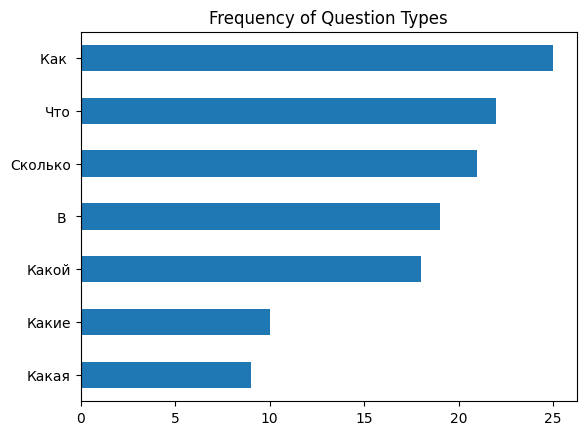

In [ ]:
#Count the questions that begin with common starting words
counts = {}
question_types = ["Что", "Как ", "Какая", "Какой", "Сколько", "В ", "Какие"]

for q in question_types:
    counts[q] = df_xq_val["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [ ]:
#Look at examples with the most common starting words
for question_type in ["Как ", "Что", "Сколько"]:
    for question in (
        df_xq_val[df_xq_val.question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

Как иначе называется огневая коробка или отделение двигателя для сжигания горючего вещества?
Как называются числа больше 1, которые можно разделить на 3 и большее количество чисел?
Как построил Тураби крепкую экономическую основу?
Что делала компания Tesla Electric Light & Manufacturing?
Что случается, когда иммунная система менее активна, чем в норме?
Что произошло, когда цианобактерии были ассимилированы?
Сколько соперничающих правителей участвовали в убийстве Шидэбалы?
Сколько тел эксгумировали ученые Public Health England? 
Сколько астронавтов было в составе экипажа, выполнявшего испытательный полет AS-206?


### Токенизация текстов датасета

Для выбора токенайзера мы будем использовать библиотек huggingface

In [ ]:
from transformers import AutoTokenizer

Поскольку наша обучающая выборка относительно невелика и содержит всего 952 примера, выберем стратегию использования сначала языковой модели, которая уже предобучена на большом наборе данных QA, таком как SQuAD и SberQuAD. Обычно  такие модели обладают значительными возможностями понимания прочитанного и служат хорошей основой для построения более точной системы.

Список извлекающих моделей для ВОС можно найти, перейдя в Hugging Face Hub и выполнив поиск «Question Answering» на вкладке «Модели».
Для русскоязычных моделей по количеству скачиваний лидируют с отрывом 2 модели: timpal0l/mdeberta-v3-base-squad2 и AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru. Предварительное исследование показало, что обе модели неплохо справляются с экстракцией ответов из текста, но первая модель требует меньше памяти и работает быстрее.

In [ ]:
# load the mdeberta-v3-base-squad2 model checkpoint from the Hugging Face Hub
model_ckpt = 'timpal0l/mdeberta-v3-base-squad2'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Попробуем сначала извлечь ответ из короткого отрывка текста

In [ ]:
# In extractive QA tasks, the inputs are provided as (question, context) pairs,
# so we pass them both to the tokenizer:
question = "Какая температура на входе паровых турбин?"
context = """В паровых турбинах температура на входе обычно составляет 565 °C
(предел текучести нержавеющей стали), а в конденсаторе — примерно 30 °C."""
inputs = tokenizer(question, context, return_tensors="pt").to(DEVICE)

Мы выбрали опцию получения объектов в формате PyTorch Tensor, так как они понадобятся нам для прямой передачи в модель. Посмотрим токенизированные входные данные в виде таблицы:

In [ ]:
#Inspect tokenized inputs
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
input_ids,1,3836,1432,46102,311,38073,325,8940,10198,5332,...,325,662,14583,617,734,260,756,425,261,2
token_type_ids,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


**Замечание:**
Тензор token_type_ids указывает, какая часть входных данных соответствует вопросу и контексту:
- 0 указывает на токен вопроса.
- 1 указывает токен контекста.

Token_type_id формируется не во всех моделях трансформаторов.
BERT-подобные модели используют идентификаторы token_type_id во время обучения, чтобы затем извлекать ответ только из контекста, но не из вопроса.

In [ ]:
#Decode the input_ids tensor
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] Какая температура на входе паровых турбин?[SEP] В паровых турбинах температура на входе обычно составляет 565 °C (предел текучести нержавеющей стали), а в конденсаторе — примерно 30 °C.[SEP]


**Примечание:** Тензор token_type_ids определяет расположение первого токена [SEP].

### Использование модели для извлечения ответа

Теперь, когда наш вопрос и контекст токенизированы, нам нужно создать экземпляр модели с QA head и подать токенизированные данные на вход модели:

In [ ]:
from transformers import AutoModelForQuestionAnswering

In [ ]:
#Instantiate the timpal0l/mdeberta model with a QA head
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt).to(DEVICE)
type(model)

transformers.models.deberta_v2.modeling_deberta_v2.DebertaV2ForQuestionAnswering

In [ ]:
#Run inputs through the forward pass
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.5384, -6.5327, -8.1024, -8.0509, -7.8044, -7.5533, -8.5148, -6.5781,
         -8.3467, -7.1717, -8.5415, -7.4526, -6.6160, -0.7370, -2.6354, -6.0648,
         -5.2702, -5.8809, -1.3810, -4.6442, -4.0448, -5.3312, -6.6316, -2.0776,
         -6.5862, -2.0931, -4.2513,  6.8889, -5.7802, -1.8775, -2.0128, -2.7108,
         -2.4782, -8.5859, -5.0079, -7.5849, -5.7989, -7.4433, -8.4409, -8.5677,
         -7.8484, -5.2636, -3.0552, -7.5127, -5.0320, -4.2929, -4.0698, -6.7754,
         -6.1926, -4.7823, -2.9103, -6.2922, -0.3619, -7.8827, -3.6411, -3.3079,
         -5.4773, -5.9341]], device='cuda:0'), end_logits=tensor([[-0.6926, -8.5509, -7.6785, -7.0349, -8.2733, -7.6216, -7.0516, -8.1667,
         -7.8490, -8.0202, -6.8300, -7.4890, -7.3856, -5.7107, -6.8617, -6.6986,
         -7.1086, -5.0646, -4.0290, -7.1668, -6.7594, -4.9112, -7.9740, -6.5558,
         -5.2935, -5.6379, -3.4733,  3.1137, -3.4401, -1.5101,  7.2332, -1.8690

Мы получили объект QuestionAnsweringModelOutput в качестве вывода "головы" ВОС. Как показано на рисунке ниже, голова  модели соответствует линейному уровню, который получает скрытые состояния от энкодера и вычисляет логиты для начального и конечного токена интервала ответа. Это означает, что мы рассматриваем ВОС как форму классификации токенов начала и конца ответа.

Чтобы преобразовать выходные данные в диапазон ответов, нам сначала нужно получить логиты для начального и конечного токенов:

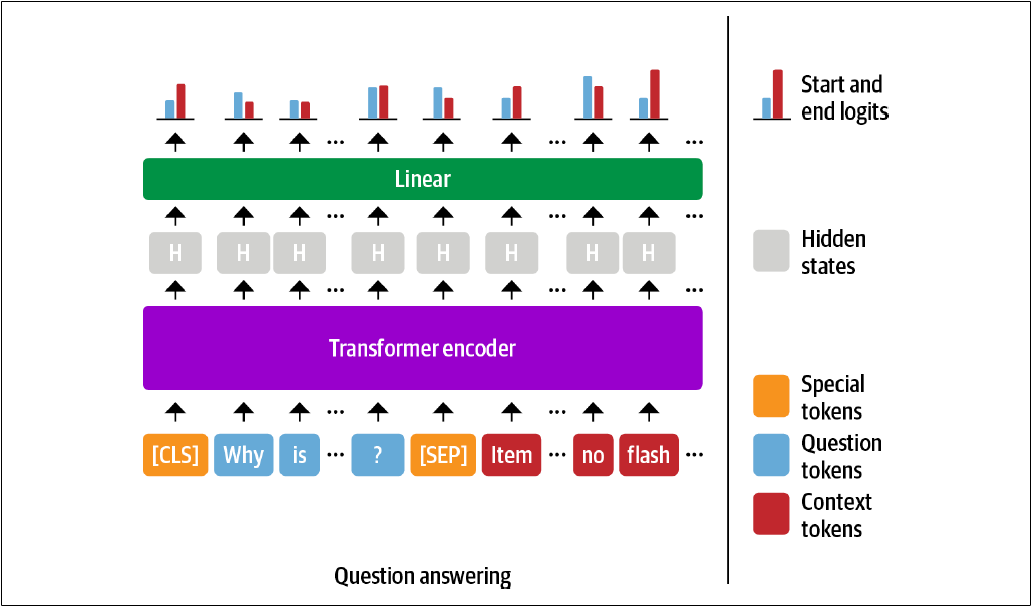

In [ ]:
# get the logits for the start and end tokens
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [ ]:
#we compare the shapes of these logits to the input IDs:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 58])
Start logits shape: torch.Size([1, 58])
End logits shape: torch.Size([1, 58])


**Замечание:** начальный и конечный логит сопоставляется с каждому токену, включая токен [CLS]

In [ ]:
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: Какая температура на входе паровых турбин?
Answer: 565 °C


**Визуализация предсказанных логитов начального и конечного токенов**

[Question Answering with a Fine-Tuned BERT](https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/)

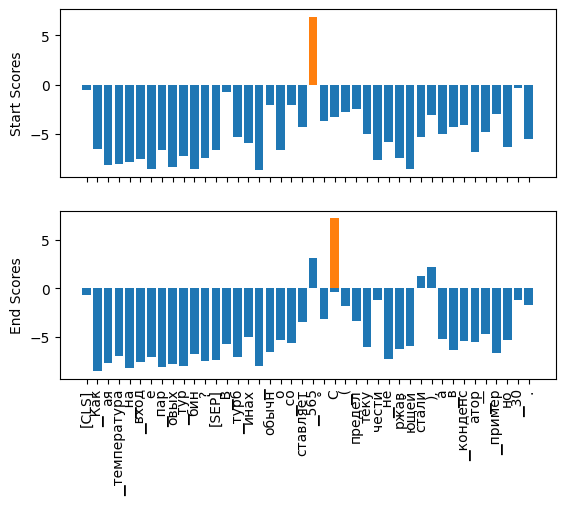

In [ ]:
s_scores = start_logits.detach().to('cpu').numpy().flatten()
e_scores = end_logits.detach().to('cpu').numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

**Примечание:**  Использование индексов с максимальными значениями начального и конечного логитов может привести к получению ответов, принадлежащих вопросу, а не контексту.  Вопросно-ответный пайплайн, который рассматривается ниже, вычисляет наилучшую комбинацию начальных и конечных индексов, используя различные ограничения, такие как положение ответа в области контекста и требуя, чтобы начальные индексы предшествовали конечным индексам.

#Постороение базовой ВОС

## Построение вопросно-ответного пайплайна с базовой моделью

In [ ]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer, device=DEVICE)
type(pipe)

transformers.pipelines.question_answering.QuestionAnsweringPipeline

In [ ]:
#Get the top 3 most likely answers to the question
pipe(question=question, context=context, top_k=3)

[{'score': 0.9702784419059753, 'start': 57, 'end': 64, 'answer': ' 565 °C'},
 {'score': 0.015769371762871742, 'start': 57, 'end': 61, 'answer': ' 565'},
 {'score': 0.00264739990234375,
  'start': 57,
  'end': 102,
  'answer': ' 565 °C\n(предел текучести нержавеющей стали),'}]


**Примечание:** Поле оценки содержит оценку вероятности модели для каждого ответа(полученого путем использования softmax над логитами).

Модель присваивает высшую начальную и конечную оценку токену [CLS], когда нет ответа на вопрос, тогда пайплайн выдает ответ в виде пустой строки.

In [ ]:
#Ask an unanswerable question
pipe(question="Почему нет данных?", context=context, handle_impossible_answer=True)

{'score': 0.989830732345581, 'start': 0, 'end': 0, 'answer': ''}

**Работа с длинными отрывками текстов**

Одна тонкость, с которой сталкиваются модели анализирующие прочитанное, заключается в том, что контекст часто содержит больше токенов, чем максимальная длина последовательности модели (которая обычно составляет не более нескольких сотен токенов). Как показано на рисунке ниже, небольшая часть контекстов из валидационного сета содержит пары вопрос-контекст, которые не вписываются в размер максимального контекста модели mdeberta, равный 512 токенам.

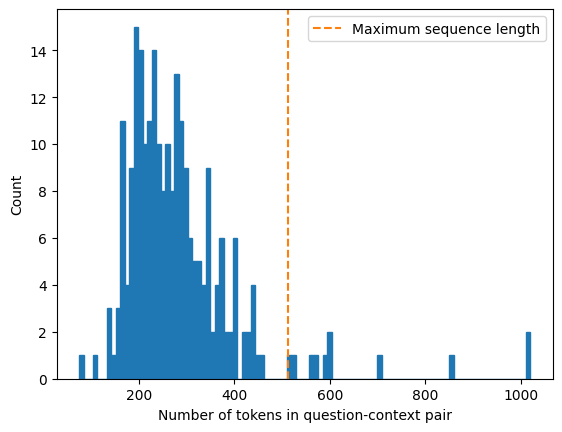

In [ ]:
#Distribution of tokens for each question-context pair in the XQuA validation set
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

df_xq_val["n_tokens"] = df_xq_val.apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
df_xq_val["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1",
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

Для других задач, таких как классификация текста, можно было бы просто обрезать длинные тексты, предполагая, что в эмбединге токена [CLS] содержится достаточно информации для создания точных прогнозов. Однако для ВОС эта стратегия не подходит, потому что ответ на вопрос может находиться ближе к концу контекста и, таким образом, будет удален в результате усечения.

На рисунке ниже представлен стандартный способ, как можно справиться с этой проблемой — применить скользящее окно к входным данным, где каждое окно содержит некоторую часть токенов, входящих в контекст модели.

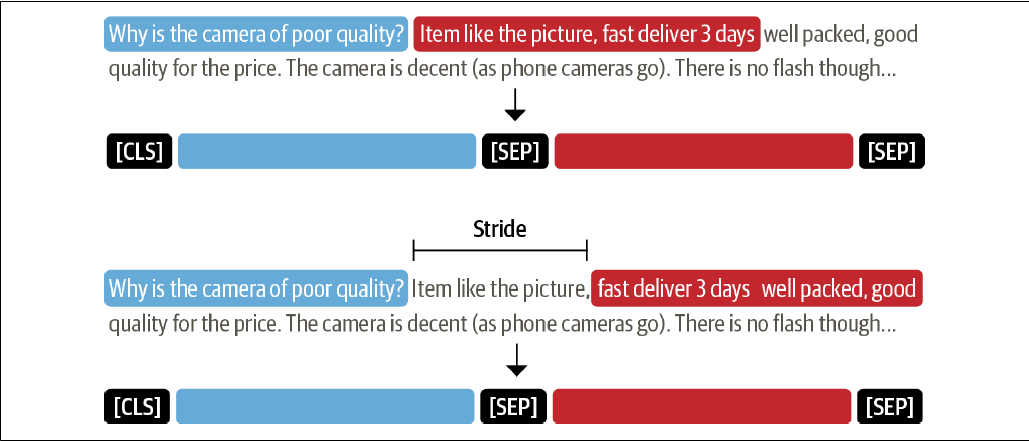

В transformers мы можем установить параметр return_overflowing_tokens=True в токенизаторе, чтобы включить скользящее окно. Размер скользящего окна управляется аргументом max_seq_length, размер шага управляется doc_stride, а величина перекрытия окон управляется параметром stride.

Ниже мы возьмем пример из нашего сета и определим небольшое окно, чтобы проиллюстрировать, как это работает:

In [ ]:
#Enable the sliding window for the tokenizer
example = df_xq_val.iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)
#Note: We now get a list containing input_ids for each window.

Мы получили списки input_ids, по одному для каждого окна. Давайте проверим количество токенов, которые у нас есть в каждом окне:

In [ ]:
#Get the number of tokens in each window
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 100 tokens
Window #2 has 100 tokens
Window #3 has 100 tokens
Window #4 has 92 tokens


Теперь давайте посмотрим, как перекрываются окна между собой декодировав входные данные.

In [ ]:
#View where the windows overlap
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] Башня Митчелла спроектирована так, чтобы быть похожей на какую Оксфордскую башню?[SEP] Первые здания кампуса Чикагского университета, которые образуют то, что теперь известно как Главный четырехугольный двор, были частью "генерального плана", задуманного двумя попечителями Чикагского университета и подготовленного чикагским архитектором Генри Ивсом Коб[SEP] 

[CLS] Башня Митчелла спроектирована так, чтобы быть похожей на какую Оксфордскую башню?[SEP]мя попечителями Чикагского университета и подготовленного чикагским архитектором Генри Ивсом Коббом. Главный четырехугольный двор состоит из шести четырехугольных дворов, каждый из которых окружен зданиями, граничащими с одним четырехугольным двором большего размера. З[SEP] 

[CLS] Башня Митчелла спроектирована так, чтобы быть похожей на какую Оксфордскую башню?[SEP] которых окружен зданиями, граничащими с одним четырехугольным двором большего размера. Здания Главного четырехугольного двора спроектировали Кобб, Шепли, Рутан и Кулидж, 

## Использование Haystack для построения BOC пайплайна

В нашем простом примере извлечения ответа мы предоставили модели и вопрос, и контекст. Однако в реальности пользователи нашей ВОС системы будут задавать вопросы по всем возможным темам, представленым в нашем датасете. Поэтому нам нужен какой-то способ выбора релевантных отрывков из всех текстов, имеющихся в датасете.

Один из способов сделать это — объединить все тексты в один и передавать их модели как единый длинный контекст.
Несмотря на простоту, недостатком этого подхода является то, что контекст может стать чрезвычайно длинным и, таким образом, привести к неприемлемой задержке для запросов пользователей.
Например, предположим, что ответ на вопрос может содержать в одном из 30 имеющихся объемных технических документов, и каждый документ обрабатывается 1 секунду. Если нам нужно обработать все документы, чтобы получить ответ, это приведет к средней задержке в 30 секунд на запрос пользователя — слишком долго для современных требований к выдаче информации веб-сайтами!

Чтобы решить эту проблему, современные системы ВОС обычно основаны на архитектуре ретривер-ридер, которая состоит из двух основных компонентов:

**Ретривер** отвечает за получение соответствующих документов по заданному запросу. Ретриверы обычно классифицируются как разреженные и плотные. Разреженные ретриверы используют частоты слов для представления каждого документа и запроса в виде разреженного вектора. Релевантность запроса и документа затем определяется путем вычисления скалярного произведения векторов.
Плотные ретриверы используют кодировщики, такие как трансформеры, для представления вопроса и документа в виде контекстуализированных эмбедингов (которые являются плотными векторами). Эти вложения кодируют семантическое значение и позволяют плотным ретриверам повысить точность поиска за счет понимания содержания запроса.

**Ридер** отвечает за извлечение ответа из документов, предоставленных ретривером. Ридер обычно является моделью извлечения из текста (например, Bert), хотя имеются варианты моделей ридеров, которые генерируют ответы в свободной форме.

Как показано на рисунке ниже, в схеме могут быть также другие компоненты, которые применяются для постобработки документов, извлеченным ретривером, или к ответам, извлеченным ридером. Например, может потребоваться повторное ранжирование извлеченных документов, чтобы исключить зашумленные или нерелевантные документы, которые могут запутать ридер. Точно так же часто требуется постобработка ответов ридера, например когда правильный ответ должен быть получен из различных отрывков длинного документа.

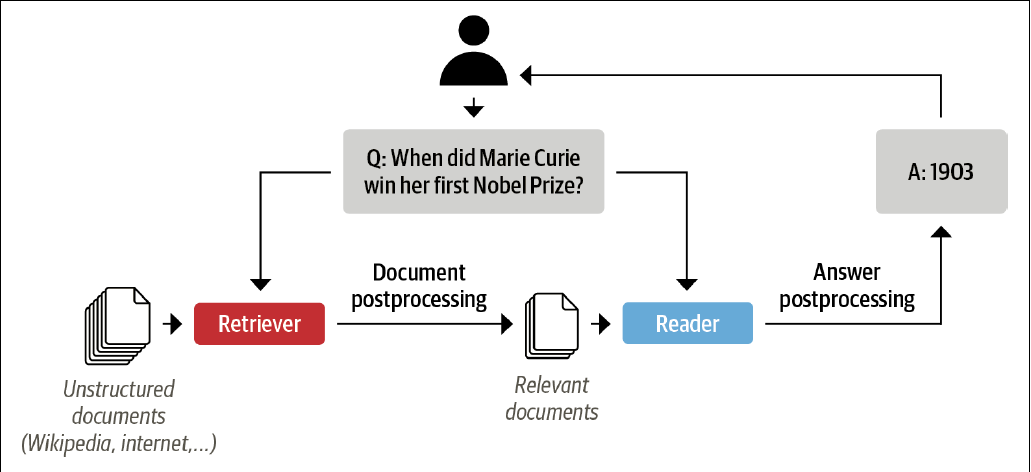

Для создания нашей ВОС мы будем использовать библиотеку Haystack, разработанную немецкой компанией Deepset, специализирующейся на NLP. Haystack основана на архитектуре ретривер-ридер и абстрагируется от многих сложностей, связанных с созданием этих систем, она также тесно интегрирована с Transformers.
Помимо ретривера и ридера, при построении ВОС с помощью Haystack будут задействованы еще два компонента:
- *Document store* - это база данных, ориентированная на документы, в которой хранятся документы и метаданные, предоставляемые ретриверу во время запроса.
- *Pipeline* объединяет все компоненты ВОС, чтобы обеспечить настройку потоков запросов пользователем, объединение документов от нескольких ретриверов и другое.

Чтобы инициализировать Document store, нам сначала нужно загрузить и установить Elasticsearch.
Следуя руководству Elasticsearch, мы можем получить последнюю версию для Linux с помощью wget и распаковать ее с помощью команды оболочки tar:

In [ ]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

Далее нам нужно запустить сервер Elasticsearch. Поскольку весь код мы запускаем в блокноте Jupyter, нам потребуется использовать функцию Python Popen() для создания нового процесса. Мы также запустим подпроцесс в фоновом режиме с помощью команды оболочки chown:

In [ ]:
from subprocess import Popen, PIPE, STDOUT

In [ ]:
#Start the Elasticsearch server
es_dir = "elasticsearch-7.9.2"

In [ ]:
!echo `pwd`/$es_dir

/content/elasticsearch-7.9.2


In [ ]:
# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 50

In [ ]:
!lsof -i :9200

COMMAND  PID   USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
java    1261 daemon  252u  IPv4  93273      0t0  TCP localhost:9200 (LISTEN)


В функции Popen() аргументы указывают программу, которую мы хотим выполнить, в то время как stdout=PIPE создает новый канал для стандартного вывода, а stderr=STDOUT собирает ошибки в том же канале. Аргумент preexec_fn указывает идентификатор подпроцесса, который мы хотим использовать. По умолчанию Elasticsearch работает локально на порту 9200, поэтому мы можем протестировать соединение, отправив HTTP-запрос на localhost:

In [ ]:
#Test the connection to the local Elasticsearch
def test_connection():
  !curl -X GET "localhost:9200/?pretty"

test_connection()

{
  "name" : "3ea74950386d",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "jgFzDH_BQlWfkd4WhyfhDw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


Теперь, когда наш сервер Elasticsearch запущен и работает, следующее, что нужно сделать, — это создать экземпляр хранилища документов:

In [ ]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

In [ ]:
# Return the document embedding for later use with dense retriever
#embedding_dim=512 sentence-transformers/distiluse-base-multilingual-cased-v1
#embedding_dim=768 berta-base
document_store = ElasticsearchDocumentStore(analyzer='russian', return_embedding=True, embedding_dim=768)

## Наполнение ElasticsearchDocumentStore данными датасета XQuAD

По умолчанию ElasticsearchDocumentStore создает два индекса в Elasticsearch: один называется document для хранения документов, а другой называется label для хранения аннотированных диапазонов ответов. Сейчас мы просто заполним индекс документов текстами из валидационного сета XQuAD.RU. Хранилище документов Haystack ожидает список словарей с текстом и мета-ключами в следующем порядке:
{
    "text": "<the-context>",
    "meta": {
    "field_01": "<additional-metadata>",
    "field_02": "<additional-metadata>",
    ...
    }
}

In [ ]:
#Flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

Поля в мета можно использовать для применения фильтров во время поиска. Для наших целей мы включим столбцы title_id и question_id, чтобы мы могли фильтровать по по статье и идентификатору вопроса.

После создания списка словарей(docs) мы можем просмотреть все тексты в нашем датафрейме и добавить их в индекс с помощью метода write_documents(), как это сделано ниже:

In [ ]:
# Populate the document index with the XQuAD.RU contexts
# Exclude duplicate contexts
docs = [{"content": row["context"],
             "meta":{"title_id": row["title"],"question_id": row["id"]}}
        for _,row in df_xq_val.drop_duplicates(subset="context").iterrows()]
print('docs[:1]=', docs[:1])
document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

docs[:1]= [{'content': '\ufeffПервые здания кампуса Чикагского университета, которые образуют то, что теперь известно как Главный четырехугольный двор, были частью "генерального плана", задуманного двумя попечителями Чикагского университета и подготовленного чикагским архитектором Генри Ивсом Коббом. Главный четырехугольный двор состоит из шести четырехугольных дворов, каждый из которых окружен зданиями, граничащими с одним четырехугольным двором большего размера. Здания Главного четырехугольного двора спроектировали Кобб, Шепли, Рутан и Кулидж, Холаберд и Роше, а также другие архитектурные фирмы, соединив викторианский готический и коллегиальный готический стили, послужившие образцом для колледжей Оксфордского университета. (Например, Башня Митчелла спроектирована по образцу оксфордской Башни Магдалены, а университетская Палата общин, Хатчинсон Холл, воспроизводит Крайст Черч Холл.)', 'meta': {'title_id': 'University_of_Chicago', 'question_id': '57284b904b864d19001648e5'}}]
Loaded 147

**Примечание:** из загружено 147 документов(context), которые присутствуют в валидационной выборке, из 240, содержащихся во всем датасете XQuAD.ru

In [ ]:
# let's see the content of docs
docs[:3]

[{'content': '\ufeffПервые здания кампуса Чикагского университета, которые образуют то, что теперь известно как Главный четырехугольный двор, были частью "генерального плана", задуманного двумя попечителями Чикагского университета и подготовленного чикагским архитектором Генри Ивсом Коббом. Главный четырехугольный двор состоит из шести четырехугольных дворов, каждый из которых окружен зданиями, граничащими с одним четырехугольным двором большего размера. Здания Главного четырехугольного двора спроектировали Кобб, Шепли, Рутан и Кулидж, Холаберд и Роше, а также другие архитектурные фирмы, соединив викторианский готический и коллегиальный готический стили, послужившие образцом для колледжей Оксфордского университета. (Например, Башня Митчелла спроектирована по образцу оксфордской Башни Магдалены, а университетская Палата общин, Хатчинсон Холл, воспроизводит Крайст Черч Холл.)',
  'meta': {'title_id': 'University_of_Chicago',
   'question_id': '57284b904b864d19001648e5'}},
 {'content': 'П

Хранилище документов Elasticsearch может быть сопряжено с любым из ретриверов Haystack, поэтому давайте начнем с использования разреженного ретривера на основе BM25 (сокращение от «Best Match 25»). BM25 — это улучшенная версия классического алгоритма TF-IDF, который представляет вопрос и контекст в виде разреженных векторов, которые можно эффективно искать в Elasticsearch. Ретривер BM25 измеряет, насколько
много совпадающего текста с поисковым запросом, и улучшает TF-IDF, быстро насыщая значения TF и нормализуя длину документа, так что короткие документы предпочтительнее длинных.

In [ ]:
# The ElasticsearchRetriever used the BM25 retriever by default.
from haystack.nodes import BM25Retriever
es_retriever = BM25Retriever(document_store=document_store)

Изучим один запрос по тексту из одной из статей

**Примечание:** Для ВОС, основанных на описаниях различных приборов, часто имеет смысл ограничить запросы одной конкретным прибором. В противном случае ретривер будет искать ответы на вопрос в описаниях, не связанных с запросом пользователя.

In [ ]:
title_id = "Steam_engine"
query = "Какая температура на входе паровых турбин?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"title_id":[title_id]})

**Примечание:**

Параметр top_k указывает, сколько документов нужно вернуть. Установленный фильтр гарантирует, что мы получим только документы(отрывки) из соответсвующей статьи. Каждый элемент retrieved_docs представляет собой объект Haystack Document, используемый для представления документов, и включает в себя оценку запроса ретривера и другие метаданные. Elasticsearch базируется на методе Lucene для индексации и поиска, поэтому по умолчанию она использует функцию оценки Lucene.

In [ ]:
#Examine three of the retrieved documents
retrieved_docs[:3]

[<Document: {'content': 'Эффективность цикла Ренкина, как правило, зависит от рабочей жидкости. Без достижения сверхкритических уровней давления для рабочей жидкости диапазон температур, в котором может работать цикл, весьма мал. В паровых турбинах температура на входе обычно составляет 565 °C (предел текучести нержавеющей стали), а в конденсаторе — примерно 30 °C. Это дает теоретический КПД цикла Карно около 63% , в сравнении с действительным КПД современной угольной электростанции 42%. Именно  благодаря низкой температуре на входе в турбину (по сравнению с газовой турбиной) цикл Ренкина нередко используется в качестве утилизационного цикла в газотурбинных электростанциях комбинированного цикла. [нет источника]', 'content_type': 'text', 'score': 0.9358339918978397, 'meta': {'title_id': 'Steam_engine', 'question_id': '57114e8d50c2381900b54a5e'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': 'cb072a7ecd184456d7a6c194c94da4cf'}>,
 <Document: {'content': 'Самым полезным прибором д

In [ ]:
sample_doc = retrieved_docs[0].to_dict()
sample_doc.update(sample_doc['meta'])
del sample_doc['meta']
pd.DataFrame(sample_doc.items()).T

,0,1,2,3,4,5,6,7
0,content,content_type,score,id_hash_keys,embedding,id,title_id,question_id
1,"Эффективность цикла Ренкина, как правило, зави...",text,0.935834,[content],None,cb072a7ecd184456d7a6c194c94da4cf,Steam_engine,57114e8d50c2381900b54a5e


**Инициализация ридера:**

В Haystack есть два типа ридеров, которые можно использовать для извлечения ответов из заданного контекста:
- **FARMReader**
на основе платформы Deepset FARM для тонкой настройки и использования трансформеров. Он совместим с моделями, обученными с помощью Transformers, и может загружать модели непосредственно из Hugging Face Hub.
- **TransformersReader**
на основе QA пайплайна от Transformers. Он подходит только для выполнения логического вывода.


В нашем случае предпочтительным является FARMReader, поскольку в FARMReader логиты не нормализованы, и ответы из различных отрывков текста легче сравнивать.

Как и в случае с Transformers, для загрузки модели нам просто нужно указать точку загрузки на Hugging Face Hub вместе с некоторыми аргументами, специфичными для этого ридера:

In [ ]:
from haystack.nodes import FARMReader, TransformersReader

In [ ]:
#Initialize a FARMReader with the mdeberta model
model_ckpt = 'timpal0l/mdeberta-v3-base-squad2' #max_seq_length=512
#model_ckpt = 'salti/bert-base-multilingual-cased-finetuned-squad' #tuned on SQuAD and XQuAD 3 epoche
#model_ckpt = 'horsbug98/Part_2_mBERT_Model_E2' #tuned on TyDiQA 2 epoche
max_seq_length, doc_stride = 512, 128       #384, 128

reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    context_window_size = 350, batch_size = 50,       #by default context_window_size = 150
                    return_no_answer=True, use_gpu=True, no_ans_boost=0,
                    use_confidence_scores = False)

**Примечание**: Мы также можем тонко настроить модель непосредственно с помощью Hugging Face Transformers и загрузить ее в TransformersReader для выполнения логических выводов.

В FARMReader работа скользящего окна управляется теми же параметрами max_seq_length и doc_stride, которые мы использовали для токенизатора. Здесь мы использовали значение max_seq_length, которое равно максимальному значения для модели 'mdeberta-v3-base-squad2'

In [ ]:
#Test the reader
question = "Какая температура на входе паровых турбин?"
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'Какая температура на входе паровых турбин?', 'no_ans_gap': 15.353090286254883, 'answers': [<Answer {'answer': '565 °C', 'type': 'extractive', 'score': 14.122140884399414, 'context': 'В паровых турбинах температура на входе обычно составляет 565 °C\n(предел текучести нержавеющей стали), а в конденсаторе — примерно 30 °C.', 'offsets_in_document': [{'start': 58, 'end': 64}], 'offsets_in_context': [{'start': 58, 'end': 64}], 'document_ids': ['96e6a529786a9636f0f0a59ffebc3a44'], 'meta': {}}>]}


In [ ]:
result = (reader.predict_on_texts(question=question, texts=[context], top_k=1))
result

{'query': 'Какая температура на входе паровых турбин?',
 'no_ans_gap': 15.353090286254883,
 'answers': [<Answer {'answer': '565 °C', 'type': 'extractive', 'score': 14.122140884399414, 'context': 'В паровых турбинах температура на входе обычно составляет 565 °C\n(предел текучести нержавеющей стали), а в конденсаторе — примерно 30 °C.', 'offsets_in_document': [{'start': 58, 'end': 64}], 'offsets_in_context': [{'start': 58, 'end': 64}], 'document_ids': ['96e6a529786a9636f0f0a59ffebc3a44'], 'meta': {}}>]}

##Сборка всех компонентов вместе
Haystack предоставляет пайплайна, который позволяет нам объединять ретривер, ридер и другие компоненты вместе в виде графа, и который можно легко настроить для каждого варианта использования. Существуют также предопределенные пайплайны, аналогичные пайплайнам Transformers, но специализированные для BOC. В данном случае нас интересует извлечение ответов, поэтому мы будем использовать ExtractiveQAPipeline, который принимает в качестве аргументов одну пару ретривер-ридер:

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline
#Note: The ExtractiveQAPipeline takes a single retriever-reader pair as its arguments.

In [ ]:
#Create an extractive QA pipeline
pipe = ExtractiveQAPipeline(reader, es_retriever)

In [ ]:
# let's see possible questions
df_xq_val[['question','answers.text']].sample(10)

,question,answers.text
427,Сколько квадратных километров дождевых лесов н...,[5 500 000]
36,Кто является генеральным менеджером Бронкоса?,[Джон Элвей]
1128,Какой период деятельности Йозефа Шумпетера и Н...,[перед Первой мировой войной]
850,В каком году тропический шторм привел к четыре...,[2008 году]
1039,Как образовалось Рейнское ущелье?,[эрозии]
290,"Назовите выдающегося производителя оружия, про...",[Э. И. Дюпон де Немур]
269,Сколько узкоколейных железных дорог раньше нах...,[пяти]
997,Сколько существует линий хлоропластов?,[трех]
892,"Как называлась серия фильма ""Доктор Кто"", для ...",[Планеты гигантов]
1077,"Как называются вопросы, выходящие за рамки зак...",[Зарезервированные]


У каждого пайплайна есть метод run(), который указывает, как должен выполняться поток запросов. Для ExtractiveQAPipeline нам просто нужно передать запрос, количество документов для извлечения с помощью top_k(retriever) и количество ответов, которые нужно извлечь из этих документов с помощью top_k(reader). В данном случае нет необходимости указывать фильтр.

In [ ]:
### Below are some difficult questions
query ='Что мешало второму вторжению Хублая в Японию?'
# correct answer = 'явившегося плохим предвестником тайфуна', preds answer = 'тайфуна'
query ='Что, по мнению Мота, действительно представляла сосбой система классов Юаня?'
# correct answer = 'степени привилегий', preds answer = ''
query ='Как называлась серия фильма "Доктор Кто", для которой Симпсон написал первую музыку?'
# correct answer = 'Планеты гигантов', preds answer = 'Планеты гигантов'
query ='Районы Южной Калифорнии хорошо известны как крупные и разбросанные территориальные сообщества, какая другая характерная черта вам известна?'
# correct answer = 'пригородными районами', preds answer = 'использованием автомобилей и шоссе'
query = 'Сколько квадратных километров дождевых лесов насчитывается в бассейне реки?'
# correct answer = '5 500 000', preds answer = ''

### Below are some simple questions
#query ='Башня Митчелла спроектирована так, чтобы быть похожей на какую Оксфордскую башню?'
# correct answer = 'Башни Магдалены', preds answer = 'Башни Магдалены'
#query = 'Какая температура на входе паровых турбин?'
# correct answer = '565 °C', preds answer = '565 °C'

In [ ]:
#Run one example
n_reader = 3
n_retriever = 3
results = pipe.run(query=query, params={"Retriever": {"top_k": n_retriever}, "Reader": {"top_k": n_reader}})
                 #filters:{"title_id": [title_id]}})
preds = [x.to_dict() for x in results["answers"]]
preds

[{'answer': '',
  'type': 'extractive',
  'score': 13.03954792022705,
  'context': None,
  'offsets_in_document': [{'start': 0, 'end': 0}],
  'offsets_in_context': [{'start': 0, 'end': 0}],
  'document_ids': None,
  'meta': {}},
 {'answer': '5 500 000',
  'type': 'extractive',
  'score': 4.1700639724731445,
  'context': 'околиственный лес, покрывающий большую часть бассейна Амазонки в Южной Америке. Бассейн охватывает 7 000 000 квадратных километров (2 700 000 квадратных миль), из которых 5 500 000 квадратных километров (2 100 000 квадратных миль) покрыты дождевыми лесами. Этот регион включает в себя территорию, принадлежащую девяти странам. Большая часть леса нахо',
  'offsets_in_document': [{'start': 433, 'end': 442}],
  'offsets_in_context': [{'start': 171, 'end': 180}],
  'document_ids': ['f70f78cd849f30f2c9f020248e8a81b8'],
  'meta': {'title_id': 'Amazon_rainforest',
   'question_id': '5729e2316aef0514001550c6'}},
 {'answer': '(22 392',
  'type': 'extractive',
  'score': -1.058672

Мы получили ряд правильных ответов, но следует обратить внимание, что, в случае более сложных вопросов, ответ не точный или даже отсутствует. Чтобы добиться большего, нам понадобятся показатели для количественной оценки производительности ретривера и ридера, которые мы рассмотрим ниже.

In [ ]:
from haystack.utils import print_answers

print_answers(results, details="all", max_text_len=100)

('Query: Сколько квадратных километров дождевых лесов насчитывается в бассейне '
 'реки?')
'Answers:'
[   <Answer {'answer': '', 'type': 'extractive', 'score': 13.03954792022705, 'context': None, 'offsets_in_document': [{'start': 0, 'end': 0}], 'offsets_in_context': [{'start': 0, 'end': 0}], 'document_ids': None, 'meta': {}}>,
    <Answer {'answer': '5 500 000', 'type': 'extractive', 'score': 4.1700639724731445, 'context': 'околиственный лес, покрывающий большую часть бассейна Амазонки в Южной Америке. Бассейн охватывает 7...', 'offsets_in_document': [{'start': 433, 'end': 442}], 'offsets_in_context': [{'start': 171, 'end': 180}], 'document_ids': ['f70f78cd849f30f2c9f020248e8a81b8'], 'meta': {'title_id': 'Amazon_rainforest', 'question_id': '5729e2316aef0514001550c6'}}>,
    <Answer {'answer': '(22 392', 'type': 'extractive', 'score': -1.058672308921814, 'context': 'ервые две автомагистрали успешно открыли дождевые леса и привели к увеличению населенных пунктов и о...', 'offsets_in_docu

# Улучшение базовой ВОС

Хотя большая часть исследований в области ВОС сосредоточена на улучшении моделей понимания прочитанного, на практике не имеет значения, насколько хорош ваш ридер, если ретривер вообще не может найти соответствующие документы! В частности, ретривер устанавливает верхнюю границу производительности всей ВОС, поэтому важно убедиться, что он хорошо справляется со своей задачей. Иcходя из этого, давайте начнем с введения некоторых общих метрик для оценки ретриверов, чтобы мы могли сравнить производительность разреженных и плотных вариантов.

## Оценка Ретривера

Распространенной метрикой для оценки ретриверов является recall, который измеряет долю всех релевантных документов, которые были извлечены. В этом контексте «релевантный» просто означает, присутствует ли ответ в отрывке текста или нет. Поэтому, имея набор вопросов, мы можем вычислить recall, подсчитав, сколько раз ответ появляется в документах top_k, возвращенных ретривером.

Оценка ретривера проводится аналогично оценке DocumentSearchPipeline для пайплайна, который состоит только из одного узла, ретривера.

In [ ]:
from haystack.pipelines import DocumentSearchPipeline
pipe = DocumentSearchPipeline(retriever=es_retriever)


Нам нужно передать в пайплайн оценки ретривера вопросы и соответствующие им ответы. Для этого мы добавим ответы в специальный указатель меток в нашем хранилище документов. Haystack предоставляет объект Label, который стандартизированно предоставляет диапазоны ответов и их метаданные. Чтобы заполнить индекс метки, мы сначала создадим список объектов метки, перебирая все вопросы в валидационном наборе и извлекая соответствующие ответы и дополнительные метаданные. *Мы не будем использовать фильтр для ограничения области поиска ретривера статьей, где находится ответ.*

In [ ]:
from haystack import Label, Answer, Document

labels = []
for i, row in df_xq_val.iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"question_id": row["id"],"title_id": row["title"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["context_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                #filters={"title_id": [row["title"]]},
                no_answer=False,)
            labels.append(label)
    # Populate labels for questions without answers
    else:
        print('else i = ', i)
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["context_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            #filters={"title_id": [row["title"]]},
            no_answer=True)
        labels.append(label)

In [ ]:
#if it is necessary we can flush labels in the document store
#if len(document_store.get_all_labels()) > 0:
#    document_store.delete_documents("label")

In [ ]:
# we can peek at one of these labels
print(labels[0])
pd.DataFrame(labels[0].to_dict().items())

<Label: {'id': 'd130ed42-9bd3-4824-9e37-bc9602cc4ff1', 'query': 'Башня Митчелла спроектирована так, чтобы быть похожей на какую Оксфордскую башню?', 'document': {'id': '175', 'content': '\ufeffПервые здания кампуса Чикагского университета, которые образуют то, что теперь известно как Главный четырехугольный двор, были частью "генерального плана", задуманного двумя попечителями Чикагского университета и подготовленного чикагским архитектором Генри Ивсом Коббом. Главный четырехугольный двор состоит из шести четырехугольных дворов, каждый из которых окружен зданиями, граничащими с одним четырехугольным двором большего размера. Здания Главного четырехугольного двора спроектировали Кобб, Шепли, Рутан и Кулидж, Холаберд и Роше, а также другие архитектурные фирмы, соединив викторианский готический и коллегиальный готический стили, послужившие образцом для колледжей Оксфордского университета. (Например, Башня Митчелла спроектирована по образцу оксфордской Башни Магдалены, а университетская Пал

,0,1
0,id,d130ed42-9bd3-4824-9e37-bc9602cc4ff1
1,query,"Башня Митчелла спроектирована так, чтобы быть ..."
2,document,"{'id': '175', 'content': '﻿Первые здания кампу..."
3,is_correct_answer,True
4,is_correct_document,True
5,origin,gold-label
6,answer,"{'answer': 'Башни Магдалены', 'type': 'extract..."
7,pipeline_id,None
8,created_at,2023-08-21 09:06:12
9,updated_at,None


**Примечание:** мы видим пару вопрос-ответ вместе с полем, которое содержит уникальный идентификатор вопроса, поэтому мы можем фильтровать хранилище документов для каждого вопроса. Мы также добавили идентификатор статьи в метаполе, чтобы мы могли фильтровать метки по статьям. Теперь, когда у нас есть метки, мы можем записать их в индекс меток в Elasticsearch как показано ниже:

In [ ]:
# we can write labels to the label index on Elasticsearch as follows
document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 238 question-answer pairs


Затем нужно создать сопоставление между нашими идентификаторами вопросов и соответствующими ответами, которые мы передаем в пайплайн. Чтобы получить все метки, мы можем использовать метод get_all_labels_aggregated() из хранилища документов, который агрегирует все пары вопрос-ответ, связанные с уникальным идентификатором.
Этот метод возвращает список объектов MultiLabel, но в нашем случае мы получаем только один элемент, так как мы фильтруем по идентификатору вопроса. Мы можем создать список агрегированных меток следующим образом:

In [ ]:
# we can build up a list of aggregated labels as follows
# if the questions are being asked to a single document, you should set open_domain=False
# we set open_domain=True to aggregate from all documents just by question
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    #aggregate_by_meta=["title_id"]  - we do not filter by article title
)
print(len(labels_agg))

238


Взглянув на одну из этих меток, мы увидим, что все ответы, связанные с данным вопросом, собраны вместе в объекте MultiLable:

In [ ]:
print(labels_agg[0])
pd.DataFrame(labels_agg[0].to_dict().items())

<MultiLabel: {'labels': [{'id': 'd130ed42-9bd3-4824-9e37-bc9602cc4ff1', 'query': 'Башня Митчелла спроектирована так, чтобы быть похожей на какую Оксфордскую башню?', 'document': {'id': '175', 'content': '\ufeffПервые здания кампуса Чикагского университета, которые образуют то, что теперь известно как Главный четырехугольный двор, были частью "генерального плана", задуманного двумя попечителями Чикагского университета и подготовленного чикагским архитектором Генри Ивсом Коббом. Главный четырехугольный двор состоит из шести четырехугольных дворов, каждый из которых окружен зданиями, граничащими с одним четырехугольным двором большего размера. Здания Главного четырехугольного двора спроектировали Кобб, Шепли, Рутан и Кулидж, Холаберд и Роше, а также другие архитектурные фирмы, соединив викторианский готический и коллегиальный готический стили, послужившие образцом для колледжей Оксфордского университета. (Например, Башня Митчелла спроектирована по образцу оксфордской Башни Магдалены, а ун

,0,1
0,labels,[{'id': 'd130ed42-9bd3-4824-9e37-bc9602cc4ff1'...
1,query,"Башня Митчелла спроектирована так, чтобы быть ..."
2,filters,None
3,id,0599f2c1212abe707833fb463e3e233e
4,no_answer,False
5,answers,[Башни Магдалены]
6,offsets_in_documents,[]
7,offsets_in_contexts,[]
8,document_ids,[175]
9,contexts,[﻿Первые здания кампуса Чикагского университет...


В версиях Haystack после 1.0 пайплайн получил метод eval(), который запускает пайплайн с входными данными из меток и возвращает прогноз и метки в формате одного кадра данных Pandas на узел пайплайна. Сохраняем этот результат в eval_result, как показано в следующей ячейке кода. По этому результу мы можем вычислить различные метрики, без повторного запуска вычислительно-затратных шагов пайплайна.

In [ ]:
# execution time with GPU - 16s
# We can run the pipeline with the desired top_k value like this
top_kr = 3
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": top_kr}},
)
metrics = eval_result.calculate_metrics()

In [ ]:
print(f"Recall@{top_kr}: {metrics['Retriever']['recall_single_hit']:.4f}")

Recall@3: 0.9790


Мы можем проверить прогнозы любого запроса, проанализировав датафрейм с результатами извлечения:

In [ ]:
eval_df = eval_result["Retriever"]
# for the correct output of the results, the exact wording of the question is required strictly from the dataset
#query1 = 'Кто написал поэму «Маскарад анархии»?'
#query1 ='Районы Южной Калифорнии хорошо известны как крупные и разбросанные территориальные сообщества, какая другая характерная черта вам известна?'
query1 ='Что, по мнению Мота, действительно представляла сосбой система классов Юаня?'
# correct answer = 'степени привилегий', preds answer = ''
#query1 ='Башня Митчелла спроектирована так, чтобы быть похожей на какую Оксфордскую башню?'
# correct answer = 'Башни Магдалены', preds answer = 'Башни Магдалены'
#query1 ='Как называлась серия фильма "Доктор Кто", для которой Симпсон написал первую музыку?'
#query1 = 'Сколько квадратных километров дождевых лесов насчитывается в бассейне реки?'
eval_df[eval_df["query"] == query1][["query", "rank","document_id","context_match","answer_match", "context"]]

,query,rank,document_id,context_match,answer_match,context
156,"Что, по мнению Мота, действительно представлял...",1.0,5c50ad7b867d4521c53fcdb9c7d7e49b,1.0,1.0,"Историк Фредерик В. Мот писал, что использован..."
157,"Что, по мнению Мота, действительно представлял...",2.0,d0bdbd2cb9fb48bf8afa75a3e58c807f,0.0,0.0,"Система бюрократии, созданная Хубилай-ханом, о..."
158,"Что, по мнению Мота, действительно представлял...",3.0,d1829020b49176f1617773e9b6c5d63a,0.0,0.0,"Император Шидэбала, сын и преемник Аюрбарибады..."


In [ ]:
eval_df.columns

Index(['multilabel_id', 'query', 'filters', 'gold_answers', 'context',
       'gold_contexts', 'gold_id_match', 'context_match', 'answer_match',
       'gold_id_or_answer_match', 'gold_id_and_answer_match',
       'gold_id_or_context_match', 'gold_id_and_context_match',
       'gold_id_and_context_and_answer_match', 'context_and_answer_match',
       'rank', 'document_id', 'gold_document_ids', 'gold_documents_id_match',
       'gold_contexts_similarity', 'gold_answers_match', 'type', 'node',
       'eval_mode', 'index'],
      dtype='object')

Если мы хотим рассчитать метрики для нескольких значений top_k, мы можем запустить пайплайн только один раз с самым высоким значением top_k, а затем вычислить метрики для меньших значений top_k.

In [ ]:
# execution time with GPU - 14s
def evaluate_retriever(retriever, topk_values = [1,2,3,4,5,7,9,12,15]):
    topk_results = {}
    # Calculate max top_k
    max_top_k = max(topk_values)
    # Create Pipeline
    p = DocumentSearchPipeline(retriever=retriever)
    # Run inference with max top_k by looping over each question-answers pair in test set
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Calculate metric for each top_k value
    for topk in topk_values:
        # Get metrics
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}

    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(es_retriever)

/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a c

Если мы построим график, то увидим, как улучшается recall по мере увеличения k:

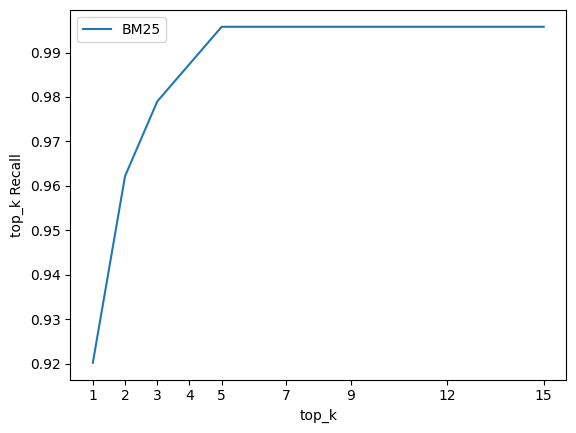

In [ ]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("top_k Recall")
    plt.xlabel("top_k")
    plt.show()

plot_retriever_eval([bm25_topk_df], ["BM25"])

**Оценка плотного ретривера**

Как мы видели, близкий к максимальному recall достигается, когда наш разреженный ретривер возвращает всего 3 документа(top_k=3), но можем ли мы добиться аналогичного результата при меньших значениях top_k? Это дало бы нам возможность передавать меньше документов ридеру и тем самым уменьшить общее время ответа нашего ВОС пайплайна. Известное ограничение разреженных ретриверов, таких как BM25, заключается в том, что они могут не находить редевантные документы, если пользовательский запрос содержит термины, которые не совпадают в точности с терминами документа. Одной из многообещающих альтернатив является использование плотных эмбедингов для представления вопроса и документа.  State-of-the-art — это архитектура, известная как Dense Passage Retrieval (DPR). Основная идея DPR — использовать две модели BERT в качестве кодировщиков для вопроса и отрывка текста. Как показано на рисунке ниже, эти кодировщики отображают входной текст в d-мерное векторное представление токена [CLS].

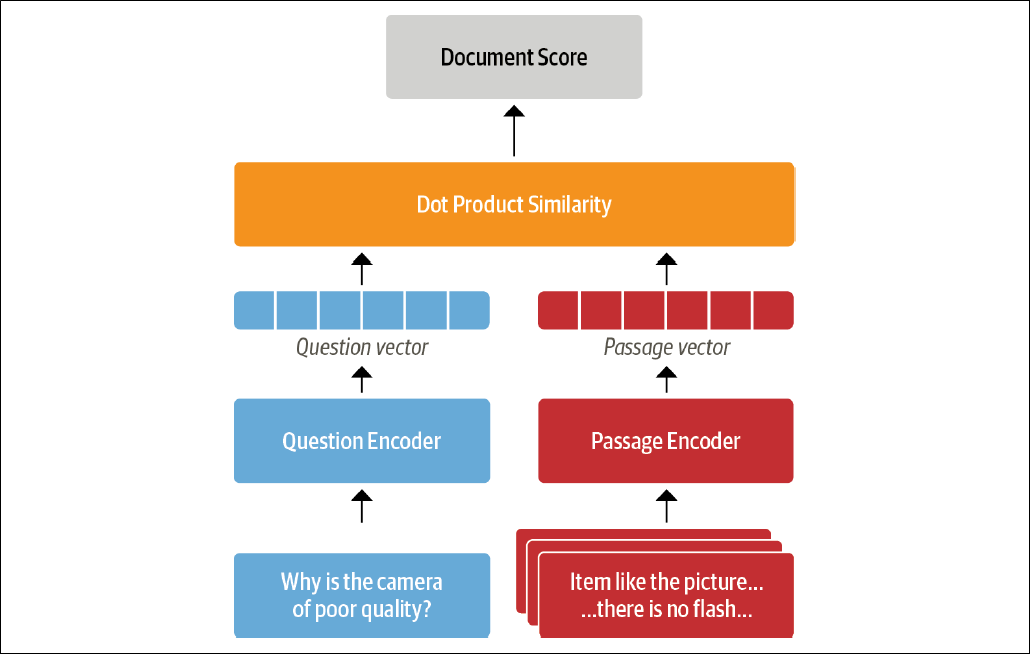

В Haystack мы можем инициализировать DPR ретривер аналогично тому, как мы это делали для BM25. В дополнение к указанию хранилища документов нам также нужно выбрать кодировщики BERT для вопроса и отрывка текста. Этих кодировщиков обучают, задавая им вопросы с релевантными (положительными) и нерелевантными (отрицательными) отрывками, где цель состоит в том, чтобы узнать, что соответствующие пары вопрос-отрывок имеют большее сходство. Для нашего варианта использования мы будем использовать кодировщики, которые были уже тонко настроены на NQ(релевантный - не релевантный) датасете.



In [ ]:
from haystack.nodes import DensePassageRetriever
#model embedding_dim=768
dpr_retriever = DensePassageRetriever(document_store=document_store,
                                  query_embedding_model="voidful/dpr-question_encoder-bert-base-multilingual",
                                  passage_embedding_model="voidful/dpr-ctx_encoder-bert-base-multilingual",
                                  max_seq_len_query=64,
                                  max_seq_len_passage=256,  #256 gives better result as 128, 384 or 512
                                  batch_size=4, #with 8 GPU overloaded
                                  use_gpu=True,
                                  embed_title=False,
                                  use_fast_tokenizers=True)

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


После того, как мы инициализировали плотный ретривер, следующим шагом будет перебор всех проиндексированных документов в индексе Elasticsearch и применение кодировщиков для обновления представления эмбедингов.

In [ ]:
# execution time without GPU - 55s
document_store.update_embeddings(retriever=dpr_retriever)

Create embeddings:  97%|█████████▋| 144/148 [00:06<00:00, 47.18 Docs/s]
Updating embeddings: 10000 Docs [00:08, 1122.24 Docs/s]


In [ ]:
# execution time with GPU - 59s
dpr_topk_df = evaluate_retriever(dpr_retriever)

/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/usr/local/lib/python3.10/dist-packages/haystack/schema.py:1465: SettingWithCopyWarning: 
A value is trying to be set on a c

Теперь мы можем оценить плотный ретривер так же, как и для
BM25 и сравнить их по top_k recall:

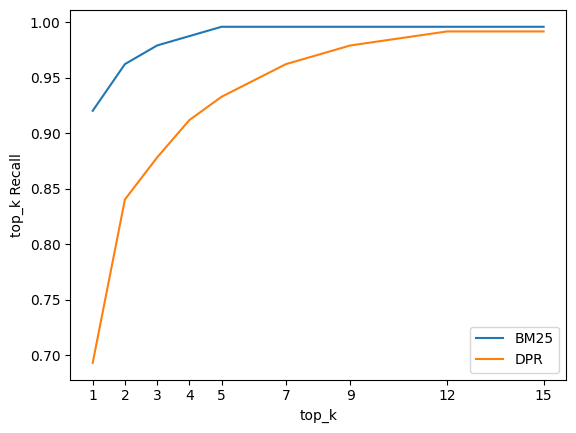

In [ ]:
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

Мы видим, что DPR не обеспечивает прирост recall по сравнению с BM25.

**Создание отчета об оценке.**

Отчет об оценке — это удобный способ для обзора всего нашего пайплайна. Он относится не к EvaluationResult, а самому классу Pipeline. Ниже приводится такой отчет.

In [ ]:
pipe.print_eval_report(eval_result)

================== Evaluation Report ==================
                   Pipeline Overview
                      Query
                        |
                        |
                      Retriever
                        |
                        | map: 0.945
                        | mrr: 0.947
                        | ndcg: 0.954
                        | precision: 0.339
                        | recall_multi_hit: 0.979
                        | recall_single_hit: 0.979
                        |
                      Output

                Wrong Retriever Examples
Query: 
 	К какому типу относится неповиновение федеральному правительству?
Gold Document Ids: 
 	142
Metrics: 
 	recall_multi_hit: 0.0
 	recall_single_hit: 0.0
 	precision: 0.0
 	map: 0.0
 	mrr: 0.0
 	ndcg: 0.0
Documents: 
 	context: Некоторые лица, проявляющие гражданское неповиновение, считают, что они обязаны соглашаться с наказанием, потому что они верят в законность социальног ...
 	document_id: f0fab0f0e46

## Оценка ридера

Для экстрактивных ВОС есть две основные метрики, которые используются для оценки ридеров:
- Точное совпадение (EM)
Двоичная метрика, которая дает EM = 1, если символы в предсказанных и базовых ответах точно совпадают, и EM = 0 в противном случае. Если ответа не ожидается, модель получает EM = 0, если она вообще предсказывает какой-либо текст.
- F1-score
Измеряет гармоническое среднее точности и полноты.

Оценка F1 — это типичный показатель для задач классификации, который широко используется в ВОС. Он подходит, когда нам одинаково важны и точность и отзыв(recall). В данном случае он вычисляется для отдельных слов в предсказании по сравнению со словами в истинном ответе. Количество общих слов между предсказанием и истиной является основой оценки F1: точность — это отношение количества общих слов к общему количеству слов в предсказании, а отзыв(recall) — это отношение количества общих слов к общему количеству слов в истинном ответе.

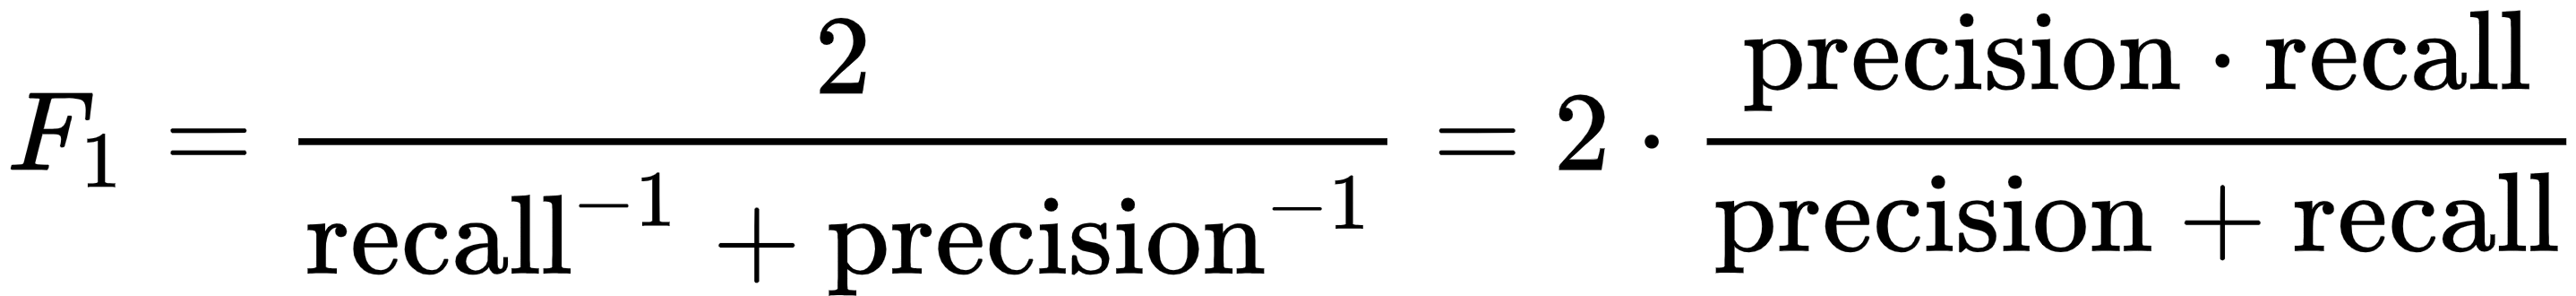

Давайте посмотрим, как работают эти метрики, импортировав некоторые вспомогательные функции из FARM и применив их к простому примеру:

In [ ]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact
# демонстрация работы метрик
pred = "около 6000 часов"
label = "6000 часов"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


Под капотом эта функция сначала нормализуют предсказание и метку, удаляя знаки препинания, исправляя пробелы и переводя в нижний регистр. Затем нормализованные строки токенизируются как набор слов перед окончательным вычислением метрики на уровне токенов. Из этого простого примера видно, что EM — гораздо более строгая метрика, чем оценка F1: добавление одного токена к прогнозу дает EM, равную нулю. С другой стороны, F1-score может не выявить действительно неверные ответы. Например, если наш прогнозируемый ответ «около 6000 рублей», то мы получаем:

In [ ]:
pred = "около 6000 рублей"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


Таким образом, полагаться только на оценку F1 не достаточно, в то время как отслеживание обеих метрик с балансировкой оценки между недооценкой (EM) и переоценкой (F1-score) является хорошей стратегией для оценки производительности модели.

Оценку ридера можно выполнить, создав пайплайн, состоящий только из одного узла: ридера. В этом случае pipe.eval() получает соответствующие документы в качестве непосредственной выдачи от меток.

In [ ]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},    #{"Reader": {"top_k": 5}}
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}, p

Теперь, когда мы пропустили каждый вопрос через ридер, давайте визуализируем результат:

In [ ]:
# execution time at GPU=5.3 GB - 43s
reader_eval = {}
evaluate_reader_out = evaluate_reader(reader)
reader_eval["Fine-tune on SQuAD"] = evaluate_reader_out[0]
pipe_reader = evaluate_reader_out[1]

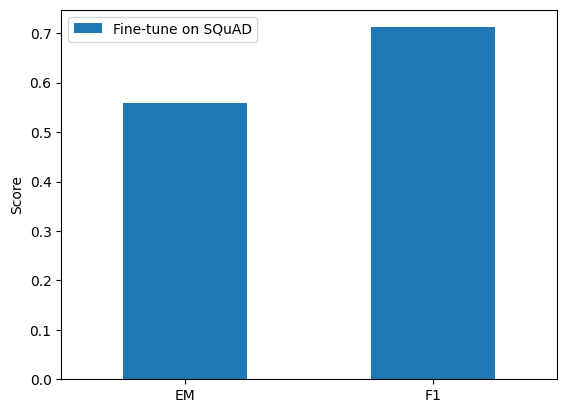

In [ ]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

In [ ]:
reader_eval

{'Fine-tune on SQuAD': {'exact_match': 0.5588235294117647,
  'f1': 0.7120130317879302}}

**Замечания:**  
1.  Результат для модели salti/bert-base-multilingual-cased-finetuned-squad выше {'exact_match': 0.5714285714285714,'f1': 0.7332102967792539}. Но эта модель уже тонко настроена на датасете XQuAD.ru и не может быть более дообучена.
2. Предобученная модель mdeberta-v3-base-squad2 на датасете XQuAD.RU показала худший результат (EM = 55.8, F1 = 71.2) , чем на датасете SQuAD2.0 (EM = 80.9, F1 = 84). Вероятно это связано с тем, что mdeberta-v3-base-squad2 обучалась отвечать на вопросы на английском языке (с переносом знаний на русский).

In [ ]:
#eval_result.wrong_examples('Rider')

## Адаптация модели к датасету

Хотя модели, которые предобученны на SQuAD, часто хорошо обобщаются на другие данные, мы видели, что для XQuAD.RU оценки EM и F1 для нашей модели были заметно хуже, чем для SQuAD. Эта неспособность обобщать также наблюдалась в других экстрактивных датасетах и рассматиривается как свидетельство того, что модели-трансформеры вероятно переобучены на SQuAD.


### Преобразование датасета в формат squad
Самый простой способ улучшить ридер — это дообучить нашу модель mdeberta-v3-base-squad2 на тренировочном наборе XQuAD.RU. FARMReader имеет метод train(), который предназначен для этой цели при условии, что данные будут точно в формате "SQuAD JSON", где все пары вопрос-ответ сгруппированы вместе для каждого элемента, как показано на рисунке ниже.

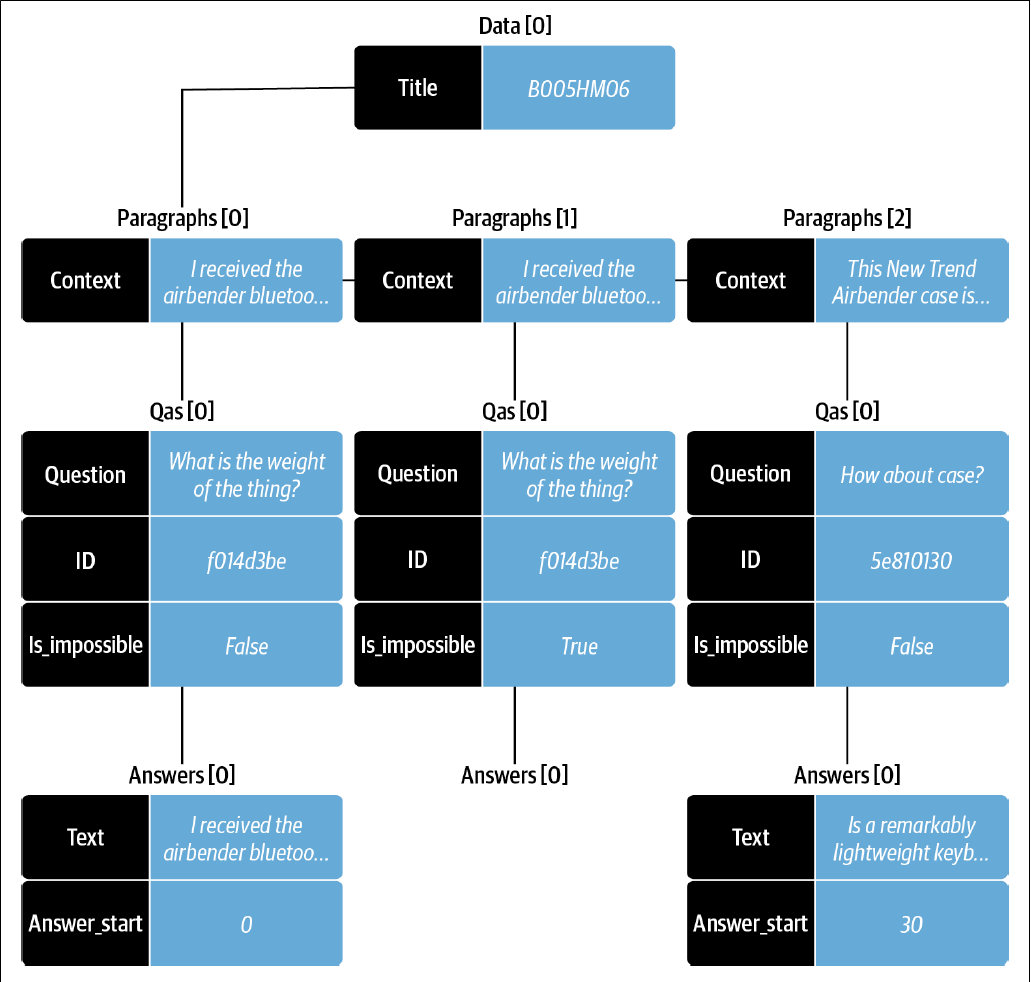

Это довольно сложный формат данных, поэтому нам понадобится несколько функций, чтобы выполнить преобразование. Первое, что нам нужно сделать, это подготовить функцию, которая может создавать массив абзацев, связанный с каждым идентификатором статьи. Каждый элемент в этом массиве содержит один контекст (отрывок статьи) и массив пар вопрос-ответ (qas). Вот функция, которая создает массив абзацев:

In [ ]:
# define a function to create the paragraphs array associated with each context_id(part of article)
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["context_id"], df["context"]))
    for context_id, context in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        context_df = df.query(f"context_id == {context_id}")
        id2question = dict(zip(context_df["id"], context_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0]
            ans_text = question_df["answers.text"][0]
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid,
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": context})
    return paragraphs


Теперь, если мы применим функцию к строкам DataFrame, связанным с одним из отрывков, мы получаем формат SQuAD:

In [ ]:
# create list of dictionaries "paragraphs"
product = df_xq_full.query("context_id == 55")
create_paragraphs(product)

[{'qas': [{'question': 'Что обычно используется в качестве источника тепла для закипания воды в паровом двигателе?',
    'id': '571144d1a58dae1900cd6d6e',
    'is_impossible': False,
    'answers': [{'text': 'сжигают горючие вещества', 'answer_start': 125}]},
   {'question': 'Как иначе называется огневая коробка или отделение двигателя для сжигания горючего вещества?',
    'id': '571144d1a58dae1900cd6d6f',
    'is_impossible': False,
    'answers': [{'text': 'камера сгорания', 'answer_start': 233}]},
   {'question': 'Какая энергия помимо ядерной, геотермальной энергии и энергии отходящего тепла от двигателей внутреннего сгорания применяется для подачи тепла в паровой машине?',
    'id': '571144d1a58dae1900cd6d70',
    'is_impossible': False,
    'answers': [{'text': 'солнечная', 'answer_start': 371}]},
   {'question': 'Какой вид нагревательного элемента часто используют в игрушечных паровых машинах?',
    'id': '571144d1a58dae1900cd6d71',
    'is_impossible': False,
    'answers': [{'t

Последним шагом является применение функции к каждому идентификатору отрывка статьи для тренировочных и валидационных данных. Следующая функция convert_to_squad() делает это и сохраняет результат в файле xquad.ru.{subset}.json:

In [ ]:
#the following function convert data to JSON and
#stores them in a xquad.ru.{subset}.json file
def convert_to_squad(df, subset = 'train'):
        xquad_data = {}
        # Create `paragraphs` for each article
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        xquad_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"xquad.ru.{subset}.json", "w+", encoding="utf-8") as f:
            json.dump(xquad_data, f)

In [ ]:
# convert our 2 datasets(train, validation) to squad fromat
convert_to_squad(df_xq_train, subset = 'train')
convert_to_squad(df_xq_val, subset = 'valid')

### Тонкая настройка модели(ридера) на датасете xquad.ru.train

In [ ]:
clean_gpu()

train_filename = "xquad.ru.train.json"
dev_filename = "xquad.ru.valid.json"

gc_number =  486
gc_number =  0


Теперь, когда у нас есть датасеты в нужном формате, давайте настроим наш ридер, указав расположение  тренировочного и валидационного сетов, а также место для сохранения настроенной модели:

In [ ]:
# execution time at GPU=12.8 GB for 2 epoches - 6min.
#2 epochs in a loop give better results than 2 epochs in one run!!!
for i in range(2):
  reader.train(data_dir='./', use_gpu=True, n_epochs=1, batch_size=4,
             train_filename=train_filename, dev_filename=dev_filename, save_dir='./model_sq+2ep/',
             grad_acc_steps= 2, learning_rate= 5e-5,
             warmup_proportion= 0.1
             )

Preprocessing dataset: 100%|██████████| 1/1 [00:00<00:00,  4.07 Dicts/s]


 Cравним производительность тонко настроенного на тренировочном наборе ридера с нашей базовой моделью:

In [ ]:
# execution time with GPU - 21s
reader_eval["Fine-tune on SQuAD + XQuAD"] = evaluate_reader(reader)[0]

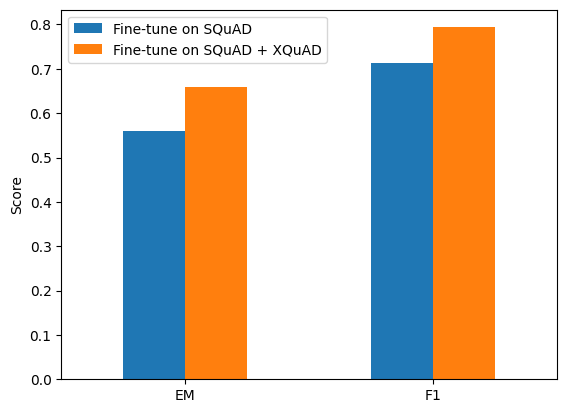

In [ ]:
plot_reader_eval(reader_eval)

In [ ]:
reader_eval

{'Fine-tune on SQuAD': {'exact_match': 0.5588235294117647,
  'f1': 0.7120130317879302},
 'Fine-tune on SQuAD + XQuAD': {'exact_match': 0.6596638655462185,
  'f1': 0.7936205845598635}}

Адаптация модели к нашему датасету только на 1-ой эпохе увеличила показатель EM с 0.559 до 0.659, и показатель F1 - с 0.712 до 0.794 (при каждом запуске тонкой настройки результаты немного меняются). Возникает вопрос, можно ли обучить языковую модель непосредственно на обучающем наборе XQuAD. Одна из причин, почему это не было сделано сразу, заключается в том, что у нас есть только 978 обучающих примеров в XQuAD, в то время как в SQuAD их более 100 000, поэтому мы можем столкнуться с проблемами переобучения. Тем не менее, давайте посмотрим,  что даст "наивная" доводка. Для честного сравнения мы будем использовать ту же языковую модель(mdeberta-v3-base), которая использовалась для тонкой настройки на SQuAD нашей базовой модели.

### Обучение не предобученной модели

In [ ]:
# clean GPU memory
clean_gpu()

gc_number =  5023
gc_number =  0


In [ ]:
# execution time - 27s
mdeberta_ckpt = "microsoft/mdeberta-v3-base"
max_seq_length1, doc_stride1 = 512, 128       #384 - 64(question) - 32(stride) = 288
mdeberta_reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length1, doc_stride=doc_stride1,
                    context_window_size = 350, batch_size = 50,       #by default context_window_size = 150
                    return_no_answer=True, use_gpu=True, no_ans_boost=0,
                    use_confidence_scores = False)

Далее мы тонко настороим модель на 3-х эпохах XQuAD.ru.train

In [ ]:
# for batch_size=4 execution time with at GPU=13.8 GB, 3 epoches - 10min
# 3 epochs in a loop give better results than 3 epochs in one run!!!
for i in range(3):
  mdeberta_reader.train(data_dir='./', use_gpu=True, n_epochs=1, batch_size=2,
             train_filename=train_filename, dev_filename=dev_filename, save_dir='./model_xq_3ep/',
             grad_acc_steps= 2, learning_rate= 5e-5,
             warmup_proportion= 0.1)

Evaluating: 100%|██████████| 129/129 [00:15<00:00,  8.48it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Evaluating: 100%|██████████| 129/129 [00:15<00:00,  8.44it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Evaluating: 100%|██████████| 129/129 [00:15<00:00,  8.22it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr

Включим эту оценку в набор тестовых оценок

In [ ]:
# execution time with GPU - 20s
reader_eval["Fine-tune on XQuAD"] = evaluate_reader(mdeberta_reader)[0]

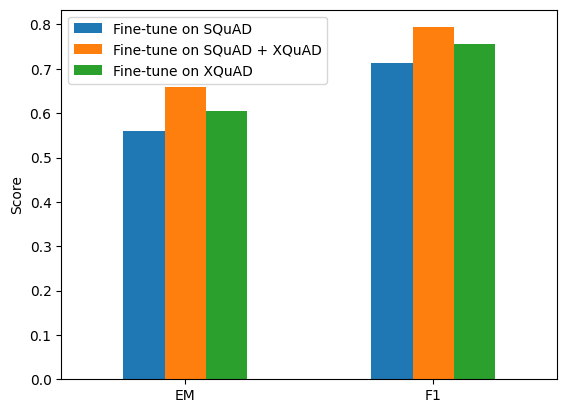

In [ ]:
plot_reader_eval({"Fine-tune on SQuAD": reader_eval["Fine-tune on SQuAD"],
                  "Fine-tune on SQuAD + XQuAD": reader_eval["Fine-tune on SQuAD + XQuAD"],
                  "Fine-tune on XQuAD": reader_eval["Fine-tune on XQuAD"]})

In [ ]:
reader_eval

{'Fine-tune on SQuAD': {'exact_match': 0.5588235294117647,
  'f1': 0.7120130317879302},
 'Fine-tune on SQuAD + XQuAD': {'exact_match': 0.6596638655462185,
  'f1': 0.7936205845598635},
 'Fine-tune on XQuAD': {'exact_match': 0.6050420168067226,
  'f1': 0.7548757854676884}}

**Вывод:** при обучении "microsoft/mdeberta-v3-base" на 3-х эпохах XQuAD.ru получен, как по метрике F1, так и по метрике ЕМ, результат немного худший, чем для модели mdeberta-v3-base-squad2, дообученной 2-х эпохах XQuAD.ru. Мы полагаем также, что модель mdeberta-v3-base-squad2 более универсальна, поскольку она обучалась на различных датасетах. Поэтому для улучшенной ВОС мы будем использовать дообученный на XQuAD вариант модели mdeberta-v3-base-squad2.

## Оценка точности улучшенной ВОС

Теперь, когда мы оценили компоненты чтения и извлечения по отдельности, свяжем их вместе, чтобы измерить общую производительность улучшенного пайплайна ВОС. Для этого нам нужно включить в наш пайплайн узлы для ридера и ретривера.
Кроме того необходимо установить оптимальное количество документов (top_k), выдаваемых ретривером. Ранее мы видели, что для разреженного ретривера recall при top_k = 1 уже достигает 0.92. Это значение значительно превышает  точность нашего оптимизированного ридера (ЕМ=0.659, F1=0.794). Опыт показал, что при значениях  top_k для ретривера более 1, ридер выдает менее точный первый ответ, что ведет к снижению точности всей системы, а также к увеличению времени ответа. В связи с этим мы определили параметр top_k  для ретривера равный «1».

In [ ]:
clean_gpu()

gc_number =  5443
gc_number =  0


In [ ]:
#load saved reader from the disk
max_seq_length,doc_stride = 320, 255       #512,128
saved_reader = FARMReader(model_name_or_path='./model_sq+2ep/', progress_bar=False,
                    context_window_size = 256,  #by default 150
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True, use_gpu=True)

In [ ]:
# время выполнения с GPU на сете "238" - 48s
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=es_retriever, reader=saved_reader)

# Evaluate
eval_result_whole = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 1}})          #by default params={"Retriever": {"top_k": 10}}

metrics = eval_result_whole.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

In [ ]:
# Save the evaluation result to the disk so that we can reload it later and calculate evaluation metrics without running the pipeline again.
#eval_result_whole.save('/content/drive/MyDrive/datasets/xquad_trained_SQ&XQ/')

Мы готовы сравнить топ 1 EM и F1 метрики для пайплайна по предсказанию ответа в документах, возвращаемых ретривром (см.на рисунке ниже).

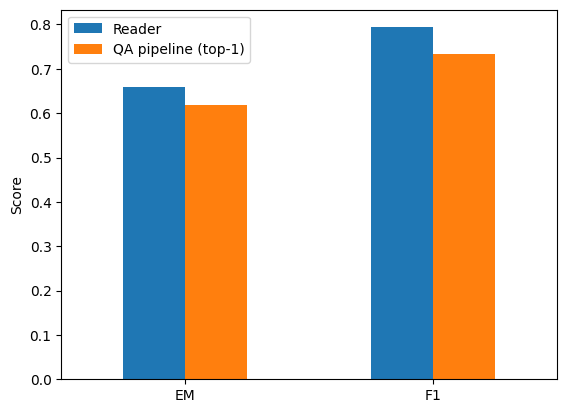

In [ ]:
#reader-vs-pipeline
#caption Comparison of EM and F1  scores for the reader against the whole QA pipeline
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + XQuAD"],
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

In [ ]:
reader_eval

{'Fine-tune on SQuAD': {'exact_match': 0.5588235294117647,
  'f1': 0.7120130317879302},
 'Fine-tune on SQuAD + XQuAD': {'exact_match': 0.6596638655462185,
  'f1': 0.7936205845598635},
 'Fine-tune on XQuAD': {'exact_match': 0.6050420168067226,
  'f1': 0.7548757854676884},
 'QA Pipeline (top-1)': {'exact_match': 0.6176470588235294,
  'f1': 0.7335715649520204}}

Влияние работы ретривера на общую производительность ВОС выражается в снижении параметра EM  c 0.659 до 0.618, а F1 – с 0.794 до 0.734. Интересно, что по параметру EM результат пайплайна относительно ридера снизился с коэффициентом 0.94, а не 0.92(точность ретривера). Это говорить о том, что в подмножестве релевантных контекстов, найденных ретривером, ридер находит правильный ответ лучше, чем во всех релевантных контекстах датасета.

In [ ]:
pipe.print_eval_report(eval_result_whole)

================== Evaluation Report ==================
                   Pipeline Overview
                      Query
                        |
                        |
                      Retriever
                        |
                        | recall_single_hit:  0.92
                        |
                      Reader
                        |
                        | exact_match: 0.626
                        | exact_match_top_1: 0.618
                        | f1: 0.742
                        | f1_top_1: 0.734
                        | num_examples_for_eval: 2.38e+02
                        | num_examples_for_eval_top_1: 2.38e+02
                        |
                      Output

                Wrong Retriever Examples
Query: 
 	Через какие два органа парламент должен пройти в первую очередь, чтобы принять закон?
Gold Document Ids: 
 	76
Metrics: 
 	recall_multi_hit: 0.0
 	recall_single_hit: 0.0
 	precision: 0.0
 	map: 0.0
 	mrr: 0.0
 	ndcg: 0.0
Documents: 
 

### Получение метрики пайплайна ВОС и Ридера за один проход:
Оценка ридера в этот раз выполняется с использованием смоделированных результатов идеального извлечения ретривером.

In [ ]:
# время выполнения с GPU на сете "238" - 1м35с
eval_result_1shot = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 1}},
    add_isolated_node_eval=True
)
metrics = eval_result_1shot.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader run in isolation with simulated perfect retriever
isolated_metrics = eval_result_1shot.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline emul (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

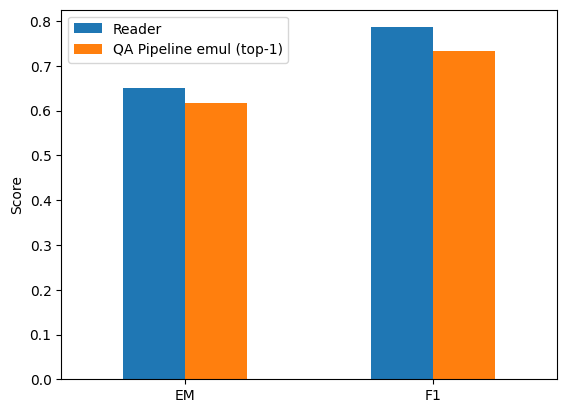

In [ ]:
plot_reader_eval(pipeline_reader_eval)

In [ ]:
pipeline_reader_eval

{'Reader': {'exact_match': 0.6512605042016807, 'f1': 0.7861509300313855},
 'QA Pipeline emul (top-1)': {'exact_match': 0.6176470588235294,
  'f1': 0.7335715649520204}}

In [ ]:
pipe.print_eval_report(eval_result_1shot)

================== Evaluation Report ==================
                   Pipeline Overview
                      Query
                        |
                        |
                      Retriever
                        |
                        | recall_single_hit:  0.92
                        |
                      Reader
                        |
                        | exact_match upper bound: 0.668
                        | exact_match: 0.626
                        | exact_match_top_1: 0.618
                        | f1 upper bound:   0.8
                        | f1: 0.742
                        | f1_top_1: 0.734
                        | num_examples_for_eval upper bound: 2.38e+02
                        | num_examples_for_eval: 2.38e+02
                        | num_examples_for_eval_top_1: 2.38e+02
                        |
                      Output

                Wrong Retriever Examples
Query: 
 	Через какие два органа парламент должен пройти в первую оче

# Применение ВОС для получения ответов по инструкции анализатора зерна Infratec



## Загрузка инструкции и  предобработка

In [ ]:
# clean GPU memory
clean_gpu()

gc_number =  10601
gc_number =  0


**Скачивание файла меньше 100 мб c Google Диска через консоль Linux**
- file_url = 'https://drive.google.com/file/d/1R7kO8ItXZR8CUDHoVKpf4MQKDKRA_HL7/view?usp=sharing'
- File_ID = 1R7kO8ItXZR8CUDHoVKpf4MQKDKRA_HL7
- wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=File_ID' -O File_Name

In [ ]:
# copy file with Foss_Infratec manual to our Google Drive
#file_url = 'https://drive.google.com/file/d/1R7kO8ItXZR8CUDHoVKpf4MQKDKRA_HL7/view?usp=sharing'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R7kO8ItXZR8CUDHoVKpf4MQKDKRA_HL7' -O Foss_Infratec_UTF8.txt

--2023-08-21 09:28:28--  https://docs.google.com/uc?export=download&id=1R7kO8ItXZR8CUDHoVKpf4MQKDKRA_HL7
Resolving docs.google.com (docs.google.com)... 142.250.145.102, 142.250.145.100, 142.250.145.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.145.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i9kf4l0816pk5ib7a6902d8g4nltvbdn/1692610050000/13332221621125605755/*/1R7kO8ItXZR8CUDHoVKpf4MQKDKRA_HL7?e=download&uuid=7ee9ddb1-ce78-44c2-8609-98abea148d43 [following]
--2023-08-21 09:28:29--  https://doc-0s-78-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/i9kf4l0816pk5ib7a6902d8g4nltvbdn/1692610050000/13332221621125605755/*/1R7kO8ItXZR8CUDHoVKpf4MQKDKRA_HL7?e=download&uuid=7ee9ddb1-ce78-44c2-8609-98abea148d43
Resolving doc-0s-78-docs.googleusercontent.com (doc-0s-78-docs.googleusercontent.com)... 142.251.18.132, 2a00:1

In [ ]:
# read the text file from disk
f = open('./Foss_Infratec_UTF8.txt', "r", encoding="utf-8")
# put the contents of the file into a variable
text = f.read()
# print a sample to make sure everything read correctly
cont = text[11000:12000]
cont


'S;\n• отсутствовали иные нарушения принятой практики эксплуатации изделия;\n• на любые компьютеры изделий установлено только программное обеспечение, одобренное компанией FOSS;\n• компьютеры любых сторонних изделий соответствуют рекомендациям представителей компании FOSS;\n• на ПК не запускались компьютерные игры, включая любые игры, установленные вместе с операционной системой;\n•\tизделие проходило надлежащее техническое обслуживание в соответствии с\nрекомендациями компании FOSS.\nВ результате износа в течение эксплуатации прибора некоторые его детали могут выходить из строя раньше, чем сам прибор. Эти детали\nперечислены в Руководстве пользователя и (или) программном обеспечении продукции FOSS, а также в Руководстве владельца.\nОтветственность в отношении изношенных деталей ограничивается случаями их повышенного износа в результате дефектов материалов или производственного брака.\n\nДиаэм - официальный дилер продукции FOSS в России; тел.: (495) 745-0508, info@dia-m.ru, www.dia-m.r

В отрывке текста много занков переноса строки(\n), также встречаются знаки табуляции(\t): мы удалим эти символы. В тексте также всречаются множественные точки(.......): мы заменим множество точек на одну.

In [ ]:
# clear text from line breaks and tabs
import re
print("Длина текста до очистки = ", len(text))
s = '''\n \t'''
text = re.sub('\s+', ' ', text)
print('Длина текста после удаления переносов и табуляции', len(text))
text = re.sub(r'([.])\1+', r'\1',text)
print("Длина текста после очистки = ", len(text))


Длина текста до очистки =  117741
Длина текста после удаления переносов и табуляции 114900
Длина текста после очистки =  114815


Посмотрим, как выглядит отрывок текста поле очистки.

In [ ]:
cont = text[11000:12000]
cont

'троя раньше, чем сам прибор. Эти детали перечислены в Руководстве пользователя и (или) программном обеспечении продукции FOSS, а также в Руководстве владельца. Ответственность в отношении изношенных деталей ограничивается случаями их повышенного износа в результате дефектов материалов или производственного брака. Диаэм - официальный дилер продукции FOSS в России; тел.: (495) 745-0508, info@dia-m.ru, www.dia-m.ru 10 FOSS Анализатор зерна Infratec™ - руководство по эксплуатации 2 Введение 2.1 Общие сведения 2.1.1 Предусмотренное применение Прибор Infratec позволяет точно анализировать такие параметры качества зерна, как белок, влажность, крахмал и масло. Анализ не требует подготовки образов. 60089460016a Рис. 1 официальный дилер продукции FOSS в России; (495) 745-0508, info@dia-m.ru, www.dia-m.ru Анализатор зерна Infratec™ - руководство по эксплуатации 60089460002а 1 Крышка 2 Конвейер 3 Отсек для образцов 4 Ящик Рис. 2 Вид Infratec спереди 5 USB-порт 6 Индикаторная лампа «Вкл» 7 Сенсорн

### Загрузка токенайзера

In [ ]:
from transformers import AutoTokenizer

#load model, which is fine tuned on SQuAD2.0 and XQuAD.ru datasets
model_ckpn = "./model_sq+2ep/"  #"./model_xq_3ep/"
tokenizer = AutoTokenizer.from_pretrained(model_ckpn)

Посмотрим длины словаря токенайзера и токенизированного текста

In [ ]:
tokenized = tokenizer.encode_plus(text, add_special_tokens=False)

In [ ]:
print('Длина токенизированного текста: ', len(tokenized['input_ids']))
print('Количество токенов в словаре токенайзера: ', len(tokenizer))

Длина токенизированного текста:  32856
Количество токенов в словаре токенайзера:  250102


Посмотрим, как работает токенайзер на простом примере.

In [ ]:
#Tokenize a question-context pair
question = 'Какие параметры позволяет анализировать прибор?'
#question = 'Как называется анализатор зерна?'
#question = 'Где сделано оборудование?'
#question = 'Какое напряжение электропитания прибора?'
#question = 'Какая информация указана на приборе?'
#question = 'Что указано на табличке на задней панели прибора?'
context = text[700:1000]
inputs = tokenizer(question, context, return_tensors="pt").to(DEVICE)

In [ ]:
#Inspect tokenized inputs
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
input_ids,1,3836,1593,41652,434,11427,12961,26605,14603,80384,...,262,17588,105461,779,33704,749,13894,516,118269,2
token_type_ids,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


**Примечание:**

Тензор token_type_ids указывает, какая часть входных данных соответствует вопросу и контексту. 0 указывает на токен вопроса. 1 указывает маркер контекста.

In [ ]:
#Decode the input_ids tensor
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] Какие параметры позволяет анализировать прибор?[SEP] ru FOSS Анализатор зерна InfratecTM - руководство по эксплуатации Информация, которая содержится в настоящем руководстве, может изменяться без предварительного уведомления. Получить сведения об обновлениях документации по вашему конкретному устройству можно, обратившись к представителю компании FOSS[SEP]


**Примечание:**

Мы видим, что токенайзер нормально работает: декодированный вопрос начинается с токена [CLS], а вопрос и контекст разделены токеном [SEP].

### Разбиение текста инструкции на части

Наша инструкция имеет относительно небольшой размер и нет необходимости для разбиения ее на части при загрузке в Elasticsearch. Однако в практическом случае может быть несколько инструкций или других документов, каждый из которых имеет значительный размер. Чтобы имитировать такой случай, мы разобьем нашу инструкцию на части по 5000 токенов и загрузим их в  Elasticsearch, как отдельные документы.

In [ ]:
#Enable the sliding window for the tokenizer
#we set return_overflowing_tokens=True in the tokenizer to enable the sliding window.
splitted_ttext = tokenizer(text,
                              return_overflowing_tokens=True, max_length=5000,
                              stride=50)

In [ ]:
#Get the number of tokens in each window
for idx, window in enumerate(splitted_ttext["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 5000 tokens
Window #1 has 5000 tokens
Window #2 has 5000 tokens
Window #3 has 5000 tokens
Window #4 has 5000 tokens
Window #5 has 5000 tokens
Window #6 has 3170 tokens


Получаем 7 отрывков текста.

**Создаем DataFrame  содержащую отрывки инструкции**

In [ ]:
#View overlaped windows
df_F = pd.DataFrame(columns = ['idx','context'])
for idx, window in enumerate(splitted_ttext["input_ids"]):
  # using loc method to append df_F dataframe
  raw_text = tokenizer.decode(window)
  df_F.loc[len(df_F)] = [idx, raw_text]
  if idx < 8:
    print(idx, f"{tokenizer.decode(window)[:70]}...{tokenizer.decode(window)[-170:]} \n")

0 [CLS] Анализатор зерна InfratecTM Руководство по эксплуатации 6008 946...в и статистических данных, их вывод на экран и (если выбрано) в другую компьютерную систему или на принтер. Все обнаруженные выбросы и отклонения выводятся вместе с [SEP] 

1 [CLS] и статистических данных, их вывод на экран и (если выбрано) в др...а для проб • Черная чаша для проб (4.5/3) используется для белой муки и других легко сжимаемых продуктов. • Серая чаша для проб (6.5/6) используется для манной крупы[SEP] 

2 [CLS] чаша для проб (4.5/3) используется для белой муки и других легко...дходящий формат. Для отчетов можно выбирать различные шаблоны и различные форматы. Путь для сохранения файлов настраивается в окне Care (Обслуживание) ISIScan Nova в[SEP] 

3 [CLS] подходящий формат. Для отчетов можно выбирать различные шаблоны ...федеральным институтом в Германии. Идентификация программного обеспечения Диаэм - официальный дилер продукции FOSS в России; тел.: (495) 745-0508, info@dia-m.ru, www[SEP] 

4 [CLS]т

**Примечания:**

Выше мы видим, что различные части инструкции (windows) имеют перекрытие между собой.

##Загрузка инструкции в ElasticsearchDocumentStore

Если мы этого не сделали раньше, инициализируем BM25 ретривер и DocumentStore

In [ ]:
from haystack.nodes import BM25Retriever
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

In [ ]:
# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(analyzer="russian", return_embedding=True, embedding_dim=768)

Очистим DocumentStore от документов и меток, которые остались там после загрузки датасета XQuAD.ru

In [ ]:
#Flush Elasticsearch to delete data from XQuAD
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

Населяем индек документов частями разделенной инструкции.

In [ ]:
#Populate the document index with the instruction parts
docs = [{"content": row["context"], "meta":{"item_id": row["idx"]}}
        for _,row in df_F.iterrows()]   #df_F.drop_duplicates(subset="context").iterrows()]
print('docs[:1]=', docs[:1])
document_store.write_documents(docs, index="document")
print(f"Loaded {document_store.get_document_count()} documents")

docs[:1]= [{'content': '[CLS] Анализатор зерна InfratecTM Руководство по эксплуатации 6008 9460 / Ред. 2 Оборудование сделано в Дании. Информация о годе выпуска изделия указана на табличке на задней панели прибора 000 «Диаэм» Москва ул. Магаданская, д. 7, к. 3 ■ тел./факс: (495) 745-0508 ■ saLes@dia-m.rj.сИа-т.щ С.-Петербург +7 (812)372-6040 spb@dia-m.ru Казань +7(843)210-2080 kazan@dia-m.ru Новосибирск +7(383)328-0048 nsk@dia-m.ru Ростов-на-Дону +7 (863) 303-5500 rnd@dia-m.ru Воронеж +7(473)232-4412 vrn@dia-m.rj Екатеринбург +7 (912) 658-7606 ekb@dia-m.ru Йошкар-Ола +7 (927)880-3676 nba@dia-m.ru Кемерово +7 (923)158-6753 kemerovo@dia-m.ruu Красноярск +7(923)303-0152 krsk@dia-m.ru Армения +7 (094) 01-0173 armenia@dia-m.ru FOSS Анализатор зерна InfratecTM - руководство по эксплуатации Информация, которая содержится в настоящем руководстве, может изменяться без предварительного уведомления. Получить сведения об обновлениях документации по вашему конкретному устройству можно, обратившись 

Инициализируем разреженный ретривер на базе алгоритма BM25

In [ ]:
# initialize BM25 retriever
es_retriever = BM25Retriever(document_store=document_store)

Инициализируем FARMReader

In [ ]:
from haystack.nodes import FARMReader

In [ ]:
#Initialize a FARMReader with our fine-tuned model

max_seq_length, doc_stride = 320, 255  #256, 128 - optimal values for search speed
reader = FARMReader(model_name_or_path=model_ckpn, progress_bar=False,
                    context_window_size = 256, batch_size = 50,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True, use_gpu=True, no_ans_boost=3,
                    use_confidence_scores = False)

**Примечание:**

Установленная опцию no_ans_boost=3 приводит к тому, что score для варианта отсутствия ответа(no_answer) повышается на 3 единицы. Мы это сделали намеренно, чтобы ВОС меньше "выдумывала", если ответа на вопрос в тексте нет.

Протестируем ридер на типичном вопросе и контексте, включающем ответ на вопрос.

In [ ]:
#Test the reader
question = 'Какая информация указана на приборе?'
print(reader.predict_on_texts(question=question, texts=[text[:12000]], top_k=3))

{'query': 'Какая информация указана на приборе?', 'no_ans_gap': 14.751686096191406, 'answers': [<Answer {'answer': 'Безопасность персонала', 'type': 'extractive', 'score': 9.860248565673828, 'context': 'Диаэм - официальный дилер продукции FOSS в России; тел.: (495) 745-0508, info@dia-m.ru, www.dia-m.ru б Анализатор зерна Infratec™ - руководство по эксплуатации 1.2 Безопасность персонала А Внимание! Если вам встречается данный символ, обязательно сверьтесь с настоящим руководством, чтобы выяснить характер возможной опасности. А Внимание! Эксплуатац', 'offsets_in_document': [{'start': 5262, 'end': 5284}], 'offsets_in_context': [{'start': 164, 'end': 186}], 'document_ids': ['dc3f9ef6ccdef035a443f9fe3824c856'], 'meta': {}}>, <Answer {'answer': 'Информация о годе выпуска изделия', 'type': 'extractive', 'score': 8.686752319335938, 'context': '\ufeffАнализатор зерна Infratec™ Руководство по эксплуатации 6008 9460 / Ред. 2 Оборудование сделано в Дании. Информация о годе выпуска изделия указана

In [ ]:
result = reader.predict_on_texts(question=question, texts=[text[:2000]], top_k=1)['answers'][0].to_dict()
pd.DataFrame(result.items())


,0,1
0,answer,Информация о годе выпуска изделия
1,type,extractive
2,score,8.686743
3,context,﻿Анализатор зерна Infratec™ Руководство по экс...
4,offsets_in_document,"[{'start': 105, 'end': 138}]"
5,offsets_in_context,"[{'start': 105, 'end': 138}]"
6,document_ids,[5a20ad8ad3f4f9ac9e2dc96b9a1354cd]
7,meta,{}


**Примечание:** мы получили правильный ответ.

###Сборка пайплайна BOC

In [ ]:
#Create an extractive QA pipeline
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, es_retriever)

In [ ]:
# Run a simple example
#question = 'Какие параметры позволяет анализировать прибор?'
#question = 'Как экспортировать результаты анализов?'#В какие форматы можно экспортировать результаты анализов?'
#question = 'Как называется анализатор зерна?'
#question = 'Где сделано оборудование?'
question = 'Какая информация указана на приборе?'
#question = 'Как изготавливаются приборы Infratec?'
#question = 'Чем ограничена ответственность в отношении изношенных деталей?'
#question = 'Какое напряжение электропитания требуется прибору?'
n_answers = 3
n_retriever = 3
results = pipe.run(query=question, params={"Retriever": {"top_k": n_retriever}, "Reader": {"top_k": n_answers}})
preds = [x.to_dict() for x in results["answers"]]

In [ ]:
# print all answers
print(f"Question: {question} \n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds[idx]['answer']}")
    print(f"Review snippet: ...{preds[idx]['context']}...")
    print(f"Answer score:{preds[idx]['score']}")
    print(f"item_id:{preds[idx]['meta']}")
    print("\n")

Question: Какая информация указана на приборе? 

Answer 1: серийный номер, версии программного обеспечения и IP-адрес
Review snippet: ...исным инженером компании FOSS. Сведения о приборе Окно Instrument Information (Сведения о приборе) содержит информацию о приборе, в том числе его серийный номер, версии программного обеспечения и IP-адрес. Рекомендуется включать эту информацию в отчеты о возникающих проблемах. Панель управления Кнопка Control Panel (Панель управления) служит для от...
Answer score:11.501741409301758
item_id:{'item_id': 3}


Answer 2: сигнатура (контрольный номер) модели прогнозирования
Review snippet: ...и «Белок» и «Влага». Такие модели должны иметь статус «Заверено» (Mosaic). Когда модели прогнозирования присваивается статус «Заверено», вычисляется сигнатура (контрольный номер) модели прогнозирования. Контрольный номер указывается в Mosaic и ISIscan Nova и включает определенный перечень настроек модели прогнозирования, влияющих на прогнозируемые ...
Answer score:8.1

**Примечание:** Мы видим, что все три ответа могут быть в принципе правильными. Из инструкции мы знаем, что точным ответом является третий. Но в инструкции сказано "на табличке на задней панели прибора", а мы спросили "на приборе", что видимо ввело модель в заблуждение.

### Получение с помощью ВОС ответов на вопросы и их анализ

**Построим таблицу с с несколькими вопросами и с тремя лучшими ответами на каждый вопрос.**

In [ ]:
questions = ['Какие параметры позволяет анализировать прибор?',
      'Как экспортировать результаты анализов?','Как называется анализатор зерна?',
      'Где сделано оборудование?','Какая информация указана на приборе?',
      'Как изготавливаются приборы Infratec?','Чем ограничена ответственность в отношении изношенных деталей?']

In [ ]:
correct_answers = ['белок, влажность, крахмал и масло', 'в форматы .CSV, rich .CSV, Excel и rich Excel',
      'InfratecTM','в Дании','Информация о годе выпуска изделия','по заданным условиям',
      'случаями их повышенного износа в результате дефектов материалов']

In [ ]:
columns = ['question','correct_answers','1 answer','2 answer','3 answer']
df_results = pd.DataFrame(columns = columns)
pred_answers = []
for i in range(len(questions)):
  results = pipe.run(query=questions[i], params={"Retriever": {"top_k": n_retriever}, "Reader": {"top_k": n_answers}})
  preds = [x.to_dict() for x in results["answers"]]
  qu_answs = [questions[i], correct_answers[i]]
  for idx in range(n_answers):
    qu_answs.append(preds[idx]['answer'])
  temp_df = pd.DataFrame([qu_answs], columns=columns)
  df_results = pd.concat([df_results,temp_df], ignore_index=True)


In [ ]:
df_results

,question,correct_answers,1 answer,2 answer,3 answer
0,Какие параметры позволяет анализировать прибор?,"белок, влажность, крахмал и масло","белок, влажность, крахмал и масло",превышении влаги в пшенице уровня 20 %,Безопасность
1,Как экспортировать результаты анализов?,"в форматы .CSV, rich .CSV, Excel и rich Excel",на принтер,"форматы.CSV, rich.CSV, Excel и rich Excel",Export Logs
2,Как называется анализатор зерна?,InfratecTM,InfratecTM,InfratecTM,InfratecTM
3,Где сделано оборудование?,в Дании,Дании,заводом-изготовителем,рабочем месте
4,Какая информация указана на приборе?,Информация о годе выпуска изделия,"серийный номер, версии программного обеспечени...",Информация о годе выпуска изделия,"адрес и номер порта сервера Mosaic, к которому..."
5,Как изготавливаются приборы Infratec?,по заданным условиям,по заданным условиям,Дании,предварительный монохроматор
6,Чем ограничена ответственность в отношении изн...,случаями их повышенного износа в результате де...,случаями их повышенного износа в результате де...,Перерыв в работе регулируемого двигателя ячейки,несортируемыми бытовыми отходами


**Комментарий к Таблице:**
1. Мы видим, что построеннай нами ВОС, выдает правильные ответы на все вопросы, которые имеют близкую формулировку к тесту.
2. Для вопросов, на которые нет точной формулировки в тексте,и которые требуют определенного осмысления, ответ не всегда правильный.

##Заключение:

**Выводы**:

1. В настоящей работе построена экстрактивная ВОС, которая показала точность на валидационной выборке датасета XQuAD.ru по метрике EM равную 0.609, а по F1 – 0.73. Данная точность является типичной для ВОС на базе моделей типа BERT-base, использованной в настоящей работе[ссылка].
2. Построенная ВОС показала хорошее понимание текста инструкции прибора Infratec: выдала 4 точных первых ответов из 7 вопросов, а в оставшихся 3 случаях выдала также близкий к правильному 1-ый или 2-ой ответ.
3. К недостаткам ВОС следует отнести:
- заметно меньшую точность работы ридера по метрике F1 в сравнении с современным benchmark (0,8 против 0.93),
- исключение предлогов в начале ответа,
- неспособность собирать ответ из нескольких мест в тесте для сложных вопросов.
4. Для частичного или полного устранения перечисленных недостатков предлагается 2 пути:
- Использование модели содержащей большее число параметров и тонкая настройка ее на достаточно большом вопросно-ответном датасете из области соответствующей применению ВОС.
- Переход от экстрактивной модели (типа Bert) в основе ВОС к модели работающей по принципу seq2seq (типа T5).

## Список ссылок
1. (https://christianjmills.com/posts/transformers-book-notes/chapter-7/#going-beyond-extractive-qa)
2. [Build Haystack QA pipeline to improve search results](https://mantiumai.com/blog/nlp/build-haystack-qa-pipeline-to-improve-search-results/)
3. [Семантический поиск с помощью Haystack и Elastic](https://procodings.ru/dev-ru/semanticheskiy-poisk-s-pomoshchyu-haystack-i-elastic/)
4. [Tutorial: Build Your First Question Answering System without elasticsearch](https://haystack.deepset.ai/tutorials/01_basic_qa_pipeline)
5. [Tutorial: Build a Scalable Question Answering System](https://haystack.deepset.ai/tutorials/03_scalable_qa_system)
6. [Introducing the new, simpler way of evaluating extractive QA pipelines in Haystack](https://www.deepset.ai/blog/how-to-evaluate-question-answering)
7. [Визуализация Question Answering with a Fine-Tuned BERT 10 Mar 2020 подробное объяснение](https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/)
8. [Cross-lingual Language Model Pretraining](https://arxiv.org/pdf/1901.07291.pdf)
9. [notebooks/07_question_answering_v2.ipynb](https://github.com/nlp-with-transformers/notebooks/blob/main/07_question_answering_v2.ipynb)
10. [Evaluating QA: Metrics, Predictions, and the Null Response](https://qa.fastforwardlabs.com/no%20answer/null%20threshold/bert/distilbert/exact%20match/f1/robust%20predictions/2020/06/09/Evaluating_BERT_on_SQuAD.html#Final-Thoughts)